In [ ]:
from google.colab import drive
import os, sys
drive.mount('/content/drive/')

Mounted at /content/drive/


# Imports

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import datetime

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import holidays

from prophet import Prophet
import math
from sklearn.metrics import mean_squared_error

from typing import Optional, Any, Tuple, List

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings("ignore")

# Statistical analysis

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/master_thesis_data/preprocessed_data.csv')
df.drop(columns=[
  'Unnamed: 0', 'Aardgas_Variabel_leveringstarief_prijsplafond_(Euro_m3)',
  'Elektriciteit_Variabel_leveringstarief_prijsplafond_(Euro_kWh)',
  'Year', 'WeekKey', 'MaxHourlyPrecipitation', 'HDMaxPrecipitation',
  'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
  'HDMaxTemperature',  'MaxHourlyMeanWindspeed', 'HDMaxMeanWindspeed',
  'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed'], inplace=True)
df['DateUTC'] = pd.to_datetime(df['DateUTC'])
df.columns

Index(['DateUTC', 'LoadConsumption', 'Date', 'Hour', 'Week', 'day_of_week',
       'DailyPrecipitation', 'DailyMeanTemperature', 'DailyMeanWindspeed',
       'Month', 'NAO', 'Biomassa', 'Windenergie', 'Zonne-energie',
       'Warmtepompen', 'Overig', 'Aardgas_Vast_leveringstarief_(Euro_jaar)',
       'Aardgas_Variabel_leveringstarief_contractprijs_(Euro_m3)',
       'Elektriciteit_Vast_leveringstarief_(Euro_jaar)',
       'Elektriciteit_Variabel_leveringstarief_contractprijs_(Euro_kWh)',
       'nat', 'sic', 'geopotential'],
      dtype='object')

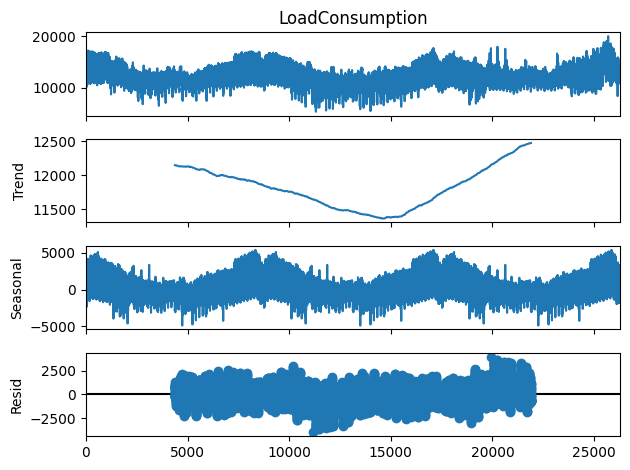

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_additive = seasonal_decompose(df['LoadConsumption'], model='additive', period=365*24)
decomposition_additive.plot()
plt.show()


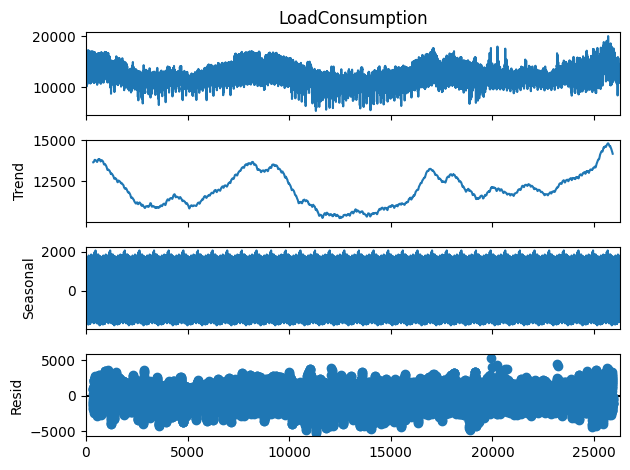

In [ ]:
decomposition_additive = seasonal_decompose(df['LoadConsumption'], model='additive', period=30*24)
decomposition_additive.plot()
plt.show()

In [ ]:
df.set_index('DateUTC', inplace=True)


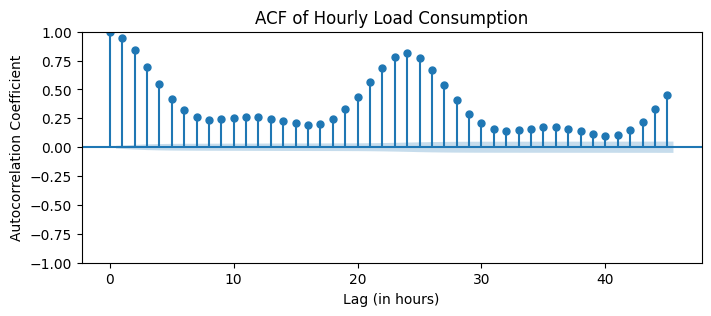

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hourly_data = df['LoadConsumption'].resample('H').sum()

fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(hourly_data, title='ACF of Hourly Load Consumption', ax=ax)
ax.set_xlabel('Lag (in hours)')
ax.set_ylabel('Autocorrelation Coefficient')

plt.show()

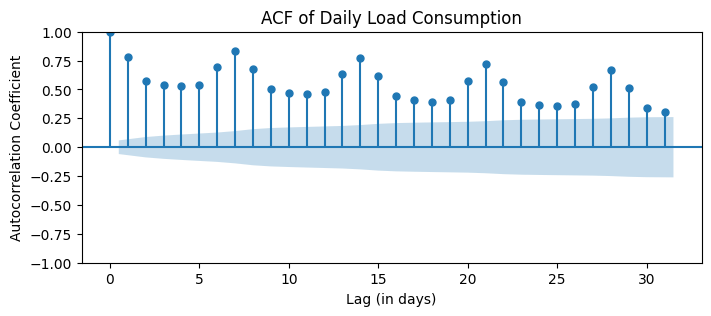

In [ ]:
daily_data = df['LoadConsumption'].resample('D').sum()

fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(daily_data, title='ACF of Daily Load Consumption', ax=ax)
ax.set_xlabel('Lag (in days)')
ax.set_ylabel('Autocorrelation Coefficient')

plt.show()

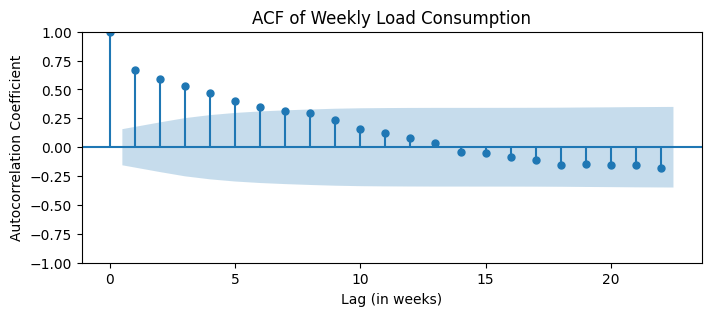

In [ ]:
weekly_data = df['LoadConsumption'].resample('W').sum()

fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(weekly_data, title='ACF of Weekly Load Consumption', ax=ax)
ax.set_xlabel('Lag (in weeks)')
ax.set_ylabel('Autocorrelation Coefficient')

plt.show()

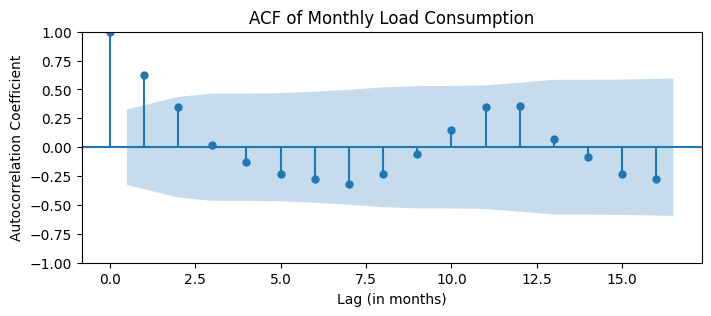

In [ ]:
monthly_data = df['LoadConsumption'].resample('M').sum()

fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(monthly_data, title='ACF of Monthly Load Consumption', ax=ax)
ax.set_xlabel('Lag (in months)')
ax.set_ylabel('Autocorrelation Coefficient')

plt.show()

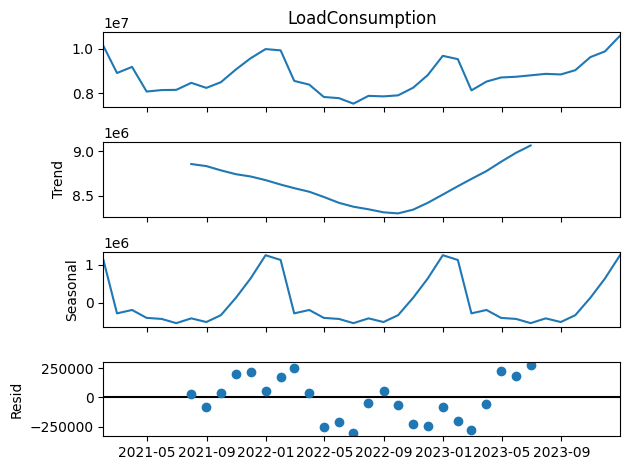

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming monthly_data is your aggregated monthly series
decomposition = seasonal_decompose(monthly_data, model='additive', period=12)
decomposition.plot()
plt.show()


# Preprocessing

In [ ]:
"""
Step 1: before data splitting
* read data
* encode strings
* create national holiday flag
* find numerical columns
"""

def read_processed_data(include_price_bool: bool, include_climate_change_bool: bool) -> pd.DataFrame:
  df = pd.read_csv('/content/drive/MyDrive/master_thesis_data/preprocessed_data.csv')
  df.drop(columns=[
    'Unnamed: 0', 'Aardgas_Variabel_leveringstarief_prijsplafond_(Euro_m3)',
    'Elektriciteit_Variabel_leveringstarief_prijsplafond_(Euro_kWh)',
    'Year', 'WeekKey', 'MaxHourlyPrecipitation', 'HDMaxPrecipitation',
    'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
    'HDMaxTemperature',  'MaxHourlyMeanWindspeed', 'HDMaxMeanWindspeed',
    'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed', 'Date', 'Hour', 'Week',
    'day_of_week','Month'], inplace=True)
  df['DateUTC'] = pd.to_datetime(df['DateUTC'])
  df.drop_duplicates(subset=['DateUTC'], keep='first', inplace=True)

  df.rename(columns={
      'DateUTC':'datetime', 'LoadConsumption':'loadConsumption',
      'DailyPrecipitation':'dailyPrecipitation','DailyMeanTemperature':'dailyMeanTemperature',
      'DailyMeanWindspeed':'dailyMeanWindspeed', 'NAO':'nao',
      'Aardgas_Vast_leveringstarief_(Euro_jaar)':'fixedGasPrice',
      'Aardgas_Variabel_leveringstarief_contractprijs_(Euro_m3)':'variableGasPrice',
      'Elektriciteit_Vast_leveringstarief_(Euro_jaar)':'fixedElectricityPrice',
      'Elektriciteit_Variabel_leveringstarief_contractprijs_(Euro_kWh)':'variableElectricityPrice',
      'Biomassa':'biomass','Windenergie':'windEnergy', 'Zonne-energie':'solarEnergy',
      'Warmtepompen':'heatPumps', 'Overig':'other',
    }, inplace=True)

  # if include_price_bool is False:
  #   df.drop(columns=[
  #      'fixedGasPrice',
  #      'variableGasPrice',
  #      'fixedElectricityPrice',
  #      'variableElectricityPrice',
  # ], inplace=True)

  # if include_climate_change_bool is False:
  #    df.drop(columns=[
  #     'dailyPrecipitation',
  #     'dailyMeanTemperature',
  #     'dailyMeanWindspeed',
  #     'nao',
  #     'biomass',
  #     'windEnergy',
  #     'solarEnergy',
  #     'heatPumps',
  #     'other'
  # ], inplace=True)
  return df


# def encode_string_columns(df: pd.DataFrame) -> pd.DataFrame:
#   """OHE the day of week (string) column."""
#   OHE = OneHotEncoder(sparse=False)
#   onehot_encoded = OHE.fit_transform(df[['day_of_week']])
#   onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=[f'day_of_week_{i}' for i in range(onehot_encoded.shape[1])])

#   df = pd.concat([df, onehot_encoded_df], axis=1)
#   df.drop(columns=['day_of_week'], inplace=True)
#   # df.drop(columns=['biomass', 'windEnergy', 'solarEnergy', 'Warmtepompen', 'Overig'], inplace=True)
#   return df


# def create_national_holiday_and_event_flag(df: pd.DataFrame) -> pd.DataFrame:
#   """Create a flag for Dutch national holidays.
#   Also flag all the days after the Ukraine Russia war started."""
#   dutch_holidays = holidays.NL()
#   df['NationalHolidayFlag'] = df['Date'].apply(lambda x: 1 if dutch_holidays.get(x) is not None  else 0)

#   date_war_ukraine_russia = datetime.date(2022, 2, 24)
#   df['Date'] = pd.to_datetime(df['Date']).dt.date
#   df['SpecialEventFlag'] = df['Date'].apply(lambda x: 1 if x >= date_war_ukraine_russia else 0)
#   df.drop(columns=['Date'], inplace=True)
#   return df


def find_numerical_columns(df: pd.DataFrame) -> list:
  """Find the numerical columns (int or float) in the given df."""
  return df.select_dtypes(include=['int64', 'float64']).columns.tolist()


"""
Step 2: remove outliers from train part of load consumption
We decide for now not to remove outliers from any of the rest of the data. Since things about weather and price are just things that are realistic to happen.
"""

def clear_outliers(df: pd.DataFrame, numerical_columns: list, start_winter: datetime.datetime) -> pd.DataFrame:
  """
  Use IQR to detect the outliers.
  Next, set them to nan.
  """
  df_train = df[df['datetime'] < start_test_wintertime]
  df_test = df[df['datetime'] >= start_test_wintertime]
  df_numerical_columns = df_train[numerical_columns]

  q1 = df_numerical_columns.quantile(0.25)
  q3 = df_numerical_columns.quantile(0.75)

  IQR = q3 - q1

  lower_bound = q1 - 1.5 * IQR
  upper_bound = q3 + 1.5 * IQR

  for col in numerical_columns:
    outliers = (df_train[col] < lower_bound[col]) | (df_train[col] > upper_bound[col])
    df_train.loc[outliers, col] = pd.NA

  df_merged = pd.concat([df_train, df_test])
  return df_merged

"""
Step 3: shift data
2 month ahead value
"""

def shift_data(df: pd.DataFrame, n_days_lag: int ) -> pd.DataFrame:
  """Shift the predictors in the dataset,
  except for y and ds and the features that are known beforehand."""

  all_columns = list(df.columns)
  all_columns.remove('datetime')
  # all_columns.remove('Date')

  df_lag = df.copy()
  lag = n_days_lag * 24

  df_lag.sort_values('datetime', inplace=True)

  for i in all_columns:
    if i not in known_features_list:
      df_lag[f"{i}-{n_days_lag}days"] = df_lag[i].shift(lag)
      if (i != 'loadConsumption'):
        df_lag.drop(columns=[i], inplace=True)

  df_lag[f"loadConsumption-{n_days_lag}days-24h"] = df_lag["loadConsumption"].shift(lag + 24)
  df_lag[f"loadConsumption-{n_days_lag}days-7days"] = df_lag["loadConsumption"].shift(lag + (24*7))

  df_lag = df_lag.iloc[lag + (24*7):] # filter on this lag because from here on we have all data again
  df_lag.reset_index(inplace=True, drop=True)

  return df_lag



"""
Step 4: split data

We do this now before the other processing step to prevent data leakage.
"""

def split_train_val_test(df: pd.DataFrame, start_test_wintertime: datetime.date) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Split the df into train/val and test data."""
  df['datetime'] = pd.to_datetime(df['datetime'])
  df_test = df[df['datetime'] >= start_test_wintertime]
  df_train_val = df[df['datetime'] < start_test_wintertime]

  df_test.reset_index(inplace=True, drop=True)

  return (df_test, df_train_val)


"""
Step 5: impute numerical columns
"""

def impute_numerical_columns(df_train_val: pd.DataFrame, df_test: pd.DataFrame, numerical_columns: List, n_days_lag: int) -> Tuple[pd.DataFrame, pd.DataFrame, List]:
  numerical_columns_lagged = [f"{i}-{n_days_lag}days" if i not in known_features_list else i for i in numerical_columns]

  # impute load consumption with fit transform
  imputer = IterativeImputer(max_iter=10, random_state=0)
  df_train_val['loadConsumption_imputed'] = imputer.fit_transform(df_train_val[['loadConsumption']])
  df_train_val['loadConsumption'] = df_train_val.apply(lambda row:
                                                      row['loadConsumption']
                                                      if pd.notnull(row['loadConsumption'])
                                                      else row['loadConsumption_imputed'],
                                                      axis=1)
  df_train_val.drop(columns=['loadConsumption_imputed'], inplace=True)

  #tmp rename column to be able to use the transform from loadConsumption
  load_consumption_columns = [f'loadConsumption-{n_days_lag}days', f'loadConsumption-{n_days_lag}days-24h', f'loadConsumption-{n_days_lag}days-7days']
  for i in load_consumption_columns:
    df_train_val_tmp = df_train_val[['datetime', i]]
    df_train_val_tmp.rename(columns={i:'loadConsumption'}, inplace=True)

    # impute load consumption lagged with transform
    df_train_val_tmp['loadConsumption_imputed'] = imputer.transform(df_train_val[['loadConsumption']])
    df_train_val_tmp['loadConsumption'] = df_train_val_tmp.apply(lambda row:
                                                                  row['loadConsumption']
                                                                  if pd.notnull(row['loadConsumption'])
                                                                  else row['loadConsumption_imputed'],
                                                                  axis=1)
    df_train_val_tmp.drop(columns=['loadConsumption_imputed'], inplace=True)

    # rename back to old name
    df_train_val_tmp.rename(columns={'loadConsumption':i}, inplace=True)

    # merge to df
    df_train_val.drop(columns=[i], inplace=True)
    df_train_val = df_train_val.merge(df_train_val_tmp, on = 'datetime', how = 'left')
    # numerical_columns_lagged.remove(i)

  imputed_columns = []

  for i in numerical_columns_lagged:
    if i not in load_consumption_columns:
      imputer = IterativeImputer(max_iter=10, random_state=0)
      df_train_val[f'{i}_imputed'] = imputer.fit_transform(df_train_val[[i]])
      df_train_val[i] = df_train_val.apply(lambda row: row[i] if pd.notnull(row[i]) else row[f'{i}_imputed'], axis=1)
      df_train_val.drop(columns=[f'{i}_imputed'], inplace=True)

      df_test[f'{i}_imputed'] = imputer.transform(df_test[[i]])
      df_test[i] = df_test.apply(lambda row: row[i] if pd.notnull(row[i]) else row[f'{i}_imputed'], axis=1)
      df_test.drop(columns=[f'{i}_imputed'], inplace=True)


  return (df_train_val, df_test, numerical_columns_lagged)


"""
Step 6: Predictor selection
"""
def select_top_n_correlated_predictors(df: pd.DataFrame, numerical_columns: list, n_predictors: int, alpha: float, n_days_lag: int) -> dict:
    """Select the top n predictors based on their Pearson correlation coefficient and return their correlation
    coefficients and p-values in a dictionary."""

    predictors_dict = {}
    time_columns = ['Hour',
                     'Week',
                     'day_of_week_1',
                     'day_of_week_2',
                     'day_of_week_3',
                     'day_of_week_4',
                     'day_of_week_5',
                     'day_of_week_6',
                     'day_of_week_0',
                     'Month'
                     ]


    for predictor in numerical_columns:
      if (predictor != 'loadConsumption') & (predictor != f'loadConsumption-{n_days_lag}days') & (predictor not in time_columns):
        corr, p_value = pearsonr(df['loadConsumption'], df[predictor])
        if p_value < alpha:
            predictors_dict[predictor] = {'corr': corr, 'p_value': p_value}

    sorted_items = sorted(predictors_dict.items(), key=lambda x: abs(x[1]['corr']), reverse=True)
    print(sorted_items)
    selected_predictors = {}
    for key, value in sorted_items[:n_predictors]:
        selected_predictors[key] = value

    predictors_list = list(selected_predictors.keys())
    print(f"These are top {n_predictors} predictors: ", predictors_list)

    return selected_predictors, predictors_list


"""
Step 7: feature selection
"""
def prepare_data_for_prophet(
    df: pd.DataFrame,
    predictors_list: list,
    use_top_n_predictors: bool,
    use_all_predictors: bool,
    use_no_predictors: bool,
    n_days_lag: int,
    ) -> pd.DataFrame:
  """Select the predictors from the df and rename date to ds and load to y."""

  if use_all_predictors:
    print("All predictors are used")
    df_prophet = df.copy()

  if use_top_n_predictors:
    print("Top n predictors are used")
    cols_to_select = predictors_list.copy()
    cols_to_select.append('datetime')
    cols_to_select.append('loadConsumption')

    df_prophet = df[cols_to_select]

  if use_no_predictors:
    print("No predictors are used")
    cols_to_select = predictors_list.copy()
    cols_to_select.append('datetime')
    cols_to_select.append('loadConsumption')
    df_prophet = df[cols_to_select]


  df_prophet.rename(columns={'datetime':'ds', 'loadConsumption':'y'}, inplace=True)

  return df_prophet


def preprocess_data(
    n_predictors: int,
    alpha: float,
    use_top_n_predictors: bool,
    use_all_predictors: bool,
    use_no_predictors: bool,
    known_features_list: list,
    start_test_wintertime: datetime.datetime,
    n_days_lag: int,
    include_price_bool: bool,
    include_climate_change_bool: bool):
  """Run all data preprocessing steps."""

  df = read_processed_data(include_price_bool, include_climate_change_bool)
  # df_encoded = encode_string_columns(df)
  # df_flagged = create_national_holiday_and_event_flag(df)
  numerical_columns = find_numerical_columns(df)

  df_flagged_outliers_cleared = clear_outliers(df, numerical_columns=['loadConsumption'], start_winter=start_test_wintertime)

  df_lag = shift_data(df_flagged_outliers_cleared, n_days_lag)

  (df_test, df_train_val) = split_train_val_test(df_lag, start_test_wintertime)

  (df_train_val, df_test, numerical_columns_lagged) = impute_numerical_columns(df_train_val, df_test, numerical_columns, n_days_lag)

  if use_all_predictors:
    predictors_list = list(df_train_val.columns)
    predictors_list.remove('datetime')
    predictors_list.remove('loadConsumption')

  elif use_top_n_predictors:
    predictors_dict, predictors_list = select_top_n_correlated_predictors(df_train_val, numerical_columns_lagged, n_predictors, alpha, n_days_lag)
    predictors_list.append(f'loadConsumption-{n_days_lag}days')
    predictors_list.append(f"loadConsumption-{n_days_lag}days-24h")
    predictors_list.append(f"loadConsumption-{n_days_lag}days-7days")

    if include_price_bool:
      price_columns=[
        f'fixedGasPrice-{n_days_lag}days',
        f'variableGasPrice-{n_days_lag}days',
        f'fixedElectricityPrice-{n_days_lag}days',
        f'variableElectricityPrice-{n_days_lag}days',
      ]

      predictors_list = predictors_list + price_columns
    if include_climate_change_bool:
      climate_change_columns=[
        f'dailyPrecipitation-{n_days_lag}days',
        f'dailyMeanTemperature-{n_days_lag}days',
        f'dailyMeanWindspeed-{n_days_lag}days',
        f'nao-{n_days_lag}days',
        f'biomass-{n_days_lag}days',
        f'windEnergy-{n_days_lag}days',
        f'solarEnergy-{n_days_lag}days',
        f'heatPumps-{n_days_lag}days',
        f'other-{n_days_lag}days'
        ]
      predictors_list = predictors_list + climate_change_columns

  else:
    predictors_list = [f'loadConsumption-{n_days_lag}days',f"loadConsumption-{n_days_lag}days-24h", f"loadConsumption-{n_days_lag}days-7days"]

  predictors_list = list(set(predictors_list))

  df_train_prophet = prepare_data_for_prophet(
      df=df_train_val,
      predictors_list=predictors_list,
      use_top_n_predictors=use_top_n_predictors,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      n_days_lag=n_days_lag
  )

  df_test_prophet = prepare_data_for_prophet(
      df=df_test,
      predictors_list=predictors_list,
      use_top_n_predictors=use_top_n_predictors,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      n_days_lag=n_days_lag
  )

  return df_train_prophet, df_test_prophet, predictors_list

In [ ]:
# df_train_prophet, df_test_prophet, predictors_list = preprocess_data(
#     n_predictors=5,
#     alpha=0.05,
#     use_top_n_predictors=True,
#     use_all_predictors=False,
#     use_no_predictors=False,
#     known_features_list=[],
#     start_test_wintertime=start_test_wintertime,
#     n_days_lag=60,
#     include_price_bool=True,
#     include_climate_change_bool=False)

In [ ]:
# df_train_prophet.columns

# Prophet

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


"""
Step 8: Prophet model: train Prophet on the training data.
Use the trained Prophet model to make predictions for the entire dataset,
including both training and test sets.
"""

def initialize_prophet(
    regressors: list,
    add_seasonality: bool,
    fourier_weekly: Optional[int],
    fourier_annual: Optional[int],
    automatic: bool):
    """
    Initialize prophet. Either with specified seasonalities or default.
    Add regressors if any are entered.
    """
    if add_seasonality:
        if automatic:
            model = Prophet(
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True,
            )
        else:
            model = Prophet(
                daily_seasonality=False,
                weekly_seasonality=fourier_weekly,
                yearly_seasonality=fourier_annual,
            )

    else:
        model = Prophet()

    if len(regressors) > 0:
        for regressor in regressors:
            model.add_regressor(regressor)

    return model

"""
Step 9: Feature engineering

Combine the Prophet predictions with other relevant features (such as temperature, energy price) to create the feature set for the LSTM model.
Scale the features if necessary to ensure that they have similar ranges.
"""

def combine_prophet_predictions_and_target(prophet_forecast, df_subset, prophet_columns_to_select, predictors_to_select):
  """
  Combine the results from Prophet with the target LoadConsumption.
  """
  df_subset['ds'] = pd.to_datetime(df_subset['ds'], format='%Y-%m-%d %H:%M:%S')
  new_predictors_to_select = predictors_to_select + ['y', 'ds']
  df_subset = df_subset[new_predictors_to_select]
  print(predictors_to_select)
  print(new_predictors_to_select)
  prophet_forecast = prophet_forecast[prophet_columns_to_select]

  df_prophet = prophet_forecast.merge(df_subset, on='ds', how='left')
  df_prophet.rename(columns={'y':'loadConsumption'}, inplace=True)

  return df_prophet

# LSTM

In [ ]:
"""
Step 10: LSTM model

Define an LSTM architecture suitable for forecasting time series data.
Split the training set into k folds for cross-validation.
"""

def fit_model(model, train_X, train_y, test_X, test_y, epochs, batch_size):
  """
  Fit model and show plot of training process.
  """
  callback = EarlyStopping(monitor='loss',patience=3, start_from_epoch=8, min_delta=0.0001)
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[callback])

  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  return model

def inverse_transform_predictions(scaler, data, colName, colNames):
  dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
  dummy[colName] = data
  dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
  return dummy[colName].values


def predict(model, test_X, scaler, df):
  """Make predictions and inverse them to scale them back"""

  yhat = model.predict(test_X)

  yhat_inversed = inverse_transform_predictions(scaler=scaler, data=yhat, colName='loadConsumption_scaled', colNames=df.columns)

  return yhat, yhat_inversed

def evaluate_predictions(test_y, yhat_inversed, scaler, df):
  test_y_inversed = inverse_transform_predictions(scaler=scaler, data=test_y, colName='loadConsumption_scaled', colNames=df.columns)

  mape = np.mean(np.abs((test_y_inversed - yhat_inversed) / test_y_inversed)) * 100
  rmse = np.sqrt(mean_squared_error(test_y_inversed, yhat_inversed))
  corr_test, p_value_test = pearsonr(test_y_inversed, yhat_inversed)
  print(f'MAPE: {mape}')
  print(f'RMSE: {rmse}')
  print(f'Correlation {corr_test} with p-value {p_value_test}')

  return mape, rmse, corr_test, p_value_test

# K-Fold Cross-Validation

For each fold:
1. Use the training portion of the data to train the LSTM model.
2. Apply the trained LSTM model to make predictions on the validation portion of the data.
3. Evaluate the performance of the model using appropriate metrics (e.g., RMSE, MAE) on the validation set.

Aggregate the performance metrics across all folds to assess the overall performance of the combined Prophet-LSTM model.


In [ ]:
def train_with_k_fold_cv(k_folds, df_lstm, train, test, huang, tan):
  tscv = TimeSeriesSplit(n_splits=k_folds)

  rmse_list = []
  corr_list = []
  mape_list = []

  for train_idx, test_idx in tscv.split(df_lstm):
    start_test_idx, end_test_idx = test_idx.min(), test_idx.max()
    start_train_idx, end_train_idx = train_idx.min(), train_idx.max()

    train = df_lstm.iloc[start_train_idx:end_train_idx,:]
    test = df_lstm.iloc[start_test_idx:end_test_idx,:]

    train.set_index('ds', inplace=True)
    test.set_index('ds', inplace=True)

    # scale data
    scaler = MinMaxScaler(feature_range=(0, 1))

    train_scaled = scaler.fit_transform(train)
    df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in train.columns])

    test_scaled = scaler.transform(test)
    df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in test.columns])

    # reorder columns
    cols_ordered = list(df_train_scaled)
    cols_ordered.remove('loadConsumption_scaled')
    cols_ordered.append('loadConsumption_scaled')
    df_train_scaled = df_train_scaled[cols_ordered]
    df_test_scaled = df_test_scaled[cols_ordered]

    # split into X and y
    train_values = df_train_scaled.values
    test_values = df_test_scaled.values

    train_X, train_y = train_values[:, :-1], train_values[:, -1]
    test_X, test_y = test_values[:, :-1], test_values[:, -1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    if huang:
      model = Sequential()
      # probeer 30/90 25/75
      # dropout minder features?
      model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
      model.add(LSTM(30, activation='relu', return_sequences=True, name='LSTM_layer_1'))
      model.add(LSTM(90, activation='relu'))
      model.add(Dense(1))
      model.compile(optimizer='adam', loss='mse')
    if tan:
      model = Sequential()
      model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
      model.add(LSTM(30, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
      model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
      model.add(LSTM(60, activation='tanh', name='LSTM_Layer_2'))
      model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
      model.add(Dense(1, activation='linear', name='Dense_Layer'))
      model.compile(optimizer='rmsprop', loss='mse')

    # fit LSTM to fold
    model = fit_model(model, train_X, train_y, test_X, test_y, epochs=50, batch_size=64)

    # predict with LSTM to fold
    yhat, yhat_inversed = predict(model, test_X, scaler, df=df_train_scaled)

    # evaluate
    mape, rmse, corr_test, p_value = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

    mape_list.append(mape)
    rmse_list.append(rmse)
    corr_list.append([corr_test, p_value])

  return mape_list, rmse_list, corr_list



In [ ]:
def run_setup(
    n_predictors: int,
    alpha: float,
    use_top_n_predictors: bool,
    use_all_predictors: bool,
    use_no_predictors: bool,
    known_features_list: list,
    start_test_wintertime: datetime.datetime,
    n_days_lag: int,
    add_seasonality: bool,
    fourier_weekly: Optional[int],
    fourier_annual: Optional[int],
    automatic: bool,
    k_folds: int,
    huang: bool,
    tan: bool,
    include_price_bool: bool,
    include_climate_change_bool: bool
    ):

  df_train_prophet, df_test_prophet, predictors_list = preprocess_data(
      n_predictors=n_predictors,
      alpha=alpha,
      use_top_n_predictors=use_top_n_predictors,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      known_features_list=known_features_list,
      start_test_wintertime=start_test_wintertime,
      n_days_lag=n_days_lag,
      include_price_bool=include_price_bool,
      include_climate_change_bool=include_climate_change_bool
  )

  # intialize model
  model = initialize_prophet(
      regressors=predictors_list,
      add_seasonality=add_seasonality,
      fourier_weekly=fourier_weekly,
      fourier_annual=fourier_annual,
      automatic=automatic
  )

  # fit model
  model.fit(df_train_prophet)

  predictions_train_validation = model.predict(df_train_prophet)
  predictions_wintertime = model.predict(df_test_prophet)

  # combine predictions
  df_lstm = combine_prophet_predictions_and_target(
    prophet_forecast=predictions_train_validation,
    df_subset=df_train_prophet,
    # prophet_columns_to_select=['trend', 'additive_terms', 'yearly', 'weekly', 'daily', 'yhat', 'ds'],
    prophet_columns_to_select=['yhat', 'ds'],
    predictors_to_select=predictors_list
  )

  # # k fold cv
  mape_list, rmse_list, corr_list = [], [], []
  mape_list, rmse_list, corr_list = train_with_k_fold_cv(
      k_folds=k_folds,
      df_lstm=df_lstm,
      train=df_train_prophet,
      test=df_test_prophet,
      huang=huang,
      tan=tan
  )

  return mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet

In [ ]:
from keras.callbacks import EarlyStopping

def run_full_model(df_lstm, df_test_prophet, predictions_wintertime, huang, tan, predictors_list):
  df_lstm = df_lstm.sort_values(by='ds')
  df_lstm.set_index('ds', inplace=True)

  # scale data
  scaler = MinMaxScaler(feature_range=(0, 1))

  train_scaled = scaler.fit_transform(df_lstm)
  df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_lstm.columns])

  df_test = combine_prophet_predictions_and_target(
      prophet_forecast=predictions_wintertime,
      df_subset=df_test_prophet,
      prophet_columns_to_select=['yhat', 'ds'],
      predictors_to_select=predictors_list
  )

  df_test.set_index('ds', inplace=True)

  df_test = df_test[df_lstm.columns]
  test_scaled = scaler.transform(df_test)
  df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_test.columns])

  # reorder columns
  cols_ordered = list(df_train_scaled)
  cols_ordered.remove('loadConsumption_scaled')
  cols_ordered.append('loadConsumption_scaled')
  df_train_scaled = df_train_scaled[cols_ordered]
  df_test_scaled = df_test_scaled[cols_ordered]

  # split into X and y
  train_values = df_train_scaled.values
  test_values = df_test_scaled.values

  train_X, train_y = train_values[:, :-1], train_values[:, -1]
  test_X, test_y = test_values[:, :-1], test_values[:, -1]

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


  print(len(train_X), len(test_X))

  print("shape", train_X.shape[1], train_X.shape[2])

  # compile LSTM
  if huang:
    model = Sequential()
    # probeer 30/90 25/75
    # dropout minder features?
    model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
    model.add(LSTM(30, activation='relu', return_sequences=True, name='LSTM_layer_1'))
    model.add(LSTM(90, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
  if tan:
    model = Sequential()
    model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
    model.add(LSTM(30, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
    model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
    model.add(LSTM(60, activation='tanh', name='LSTM_Layer_2'))
    model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
    model.add(Dense(1, activation='linear', name='Dense_Layer'))
    model.compile(optimizer='rmsprop', loss='mse')


  # fit LSTM to fold
  callback = EarlyStopping(monitor='loss',patience=3, start_from_epoch=8, min_delta=0.0001)
  history = model.fit(train_X, train_y, epochs=50, batch_size=64, verbose=2, shuffle=False, callbacks=[callback])

  # plot history
  plt.plot(history.history['loss'], label='train')
  # plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  yhat, yhat_inversed = predict(model, test_X, scaler, df=df_train_scaled)

  # evaluate
  mape, rmse, corr_test, p_value = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

  return mape, rmse, corr_test, p_value, yhat_inversed, yhat

# Set standard params

In [ ]:
known_features_list = [
      # 'Hour',  'Month', 'Week',
      # 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
      # 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
      # 'NationalHolidayFlag'
  ]
start_test_wintertime = datetime.datetime(2023, 12, 1, 0, 0, 0)
n_predictors=5
alpha=0.05
use_top_n_predictors=True
use_all_predictors=False
use_no_predictors=False
n_days_lag=60

# All predictors

### Tan

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/5g8ckdtb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/4e9hijue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89284', 'data', 'file=/tmp/tmp_oge6qew/5g8ckdtb.json', 'init=/tmp/tmp_oge6qew/4e9hijue.json', 'output', 'file=/tmp/tmp_oge6qew/prophet_modelntb8ykza/prophet_model-20240530201721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['variableElectricityPrice-60days', 'fixedElectricityPrice-60days', 'loadConsumption-60days-24h', 'dailyMeanWindspeed-60days', 'dailyMeanTemperature-60days', 'sic-60days', 'loadConsumption-60days-7days', 'fixedGasPrice-60days', 'other-60days', 'nat-60days', 'nao-60days', 'variableGasPrice-60days', 'biomass-60days', 'windEnergy-60days', 'geopotential-60days', 'loadConsumption-60days', 'heatPumps-60days', 'dailyPrecipitation-60days', 'solarEnergy-60days']
['variableElectricityPrice-60days', 'fixedElectricityPrice-60days', 'loadConsumption-60days-24h', 'dailyMeanWindspeed-60days', 'dailyMeanTemperature-60days', 'sic-60days', 'loadConsumption-60days-7days', 'fixedGasPrice-60days', 'other-60days', 'nat-60days', 'nao-60days', 'variableGasPrice-60days', 'biomass-60days', 'windEnergy-60days', 'geopotential-60days', 'loadConsumption-60days', 'heatPumps-60days', 'dailyPrecipitation-60days', 'solarEnergy-60days', 'y', 'ds']
Epoch 1/50
94/94 - 5s - loss: 0.0377 - val_loss: 0.0548 - 5s/epoch - 48ms

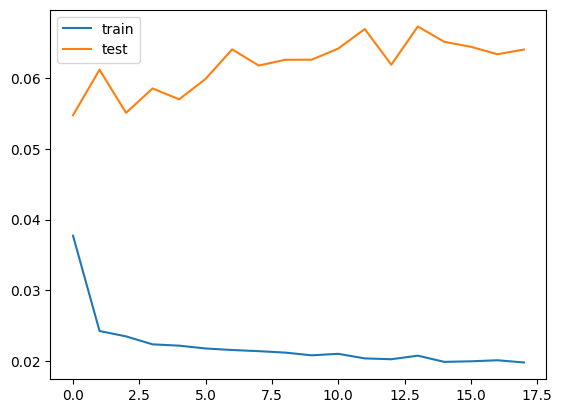

187/187 [==============================] - 1s 2ms/step
MAPE: 20.642970172739115
RMSE: 2552.3326712503267
Correlation 0.036912697366998454 with p-value 0.00430568890126504
Epoch 1/50
187/187 - 4s - loss: 0.0361 - val_loss: 0.0372 - 4s/epoch - 23ms/step
Epoch 2/50
187/187 - 1s - loss: 0.0252 - val_loss: 0.0375 - 1s/epoch - 5ms/step
Epoch 3/50
187/187 - 1s - loss: 0.0245 - val_loss: 0.0372 - 968ms/epoch - 5ms/step
Epoch 4/50
187/187 - 1s - loss: 0.0240 - val_loss: 0.0374 - 835ms/epoch - 4ms/step
Epoch 5/50
187/187 - 1s - loss: 0.0235 - val_loss: 0.0353 - 1s/epoch - 6ms/step
Epoch 6/50
187/187 - 1s - loss: 0.0229 - val_loss: 0.0350 - 1s/epoch - 7ms/step
Epoch 7/50
187/187 - 1s - loss: 0.0225 - val_loss: 0.0346 - 1s/epoch - 7ms/step
Epoch 8/50
187/187 - 1s - loss: 0.0219 - val_loss: 0.0335 - 1s/epoch - 7ms/step
Epoch 9/50
187/187 - 1s - loss: 0.0218 - val_loss: 0.0324 - 1s/epoch - 7ms/step
Epoch 10/50
187/187 - 1s - loss: 0.0213 - val_loss: 0.0312 - 1s/epoch - 7ms/step
Epoch 11/50
187/187 -

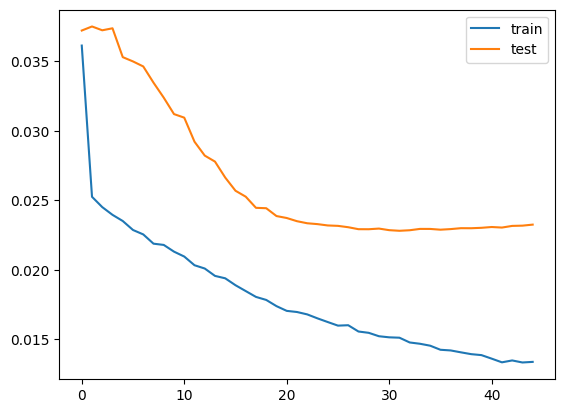

187/187 [==============================] - 1s 2ms/step
MAPE: 11.131036461191727
RMSE: 1615.2751671743047
Correlation 0.5702507186391008 with p-value 0.0
Epoch 1/50
281/281 - 6s - loss: 0.0324 - val_loss: 0.0427 - 6s/epoch - 21ms/step
Epoch 2/50
281/281 - 1s - loss: 0.0259 - val_loss: 0.0392 - 1s/epoch - 4ms/step
Epoch 3/50
281/281 - 1s - loss: 0.0251 - val_loss: 0.0368 - 1s/epoch - 4ms/step
Epoch 4/50
281/281 - 1s - loss: 0.0240 - val_loss: 0.0361 - 1s/epoch - 5ms/step
Epoch 5/50
281/281 - 1s - loss: 0.0234 - val_loss: 0.0330 - 1s/epoch - 5ms/step
Epoch 6/50
281/281 - 1s - loss: 0.0226 - val_loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 7/50
281/281 - 1s - loss: 0.0218 - val_loss: 0.0288 - 1s/epoch - 4ms/step
Epoch 8/50
281/281 - 1s - loss: 0.0214 - val_loss: 0.0290 - 1s/epoch - 5ms/step
Epoch 9/50
281/281 - 2s - loss: 0.0207 - val_loss: 0.0281 - 2s/epoch - 6ms/step
Epoch 10/50
281/281 - 2s - loss: 0.0202 - val_loss: 0.0265 - 2s/epoch - 6ms/step
Epoch 11/50
281/281 - 2s - loss: 0.0196 - val

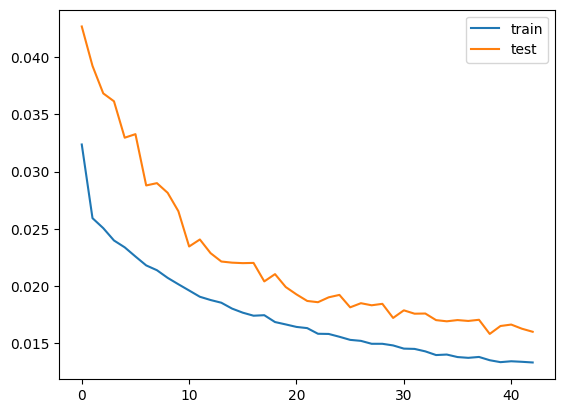

187/187 [==============================] - 3s 3ms/step
MAPE: 8.255035110636264
RMSE: 1345.0240203550907
Correlation 0.7755118378782041 with p-value 0.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=True,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=False,
    tan=True,
    include_price_bool=False,
    include_climate_change_bool=False
)

In [ ]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1837.5439529265739
avg corr 0.4608917512947677
avg mape 13.343013914855703


In [ ]:
for i in range(3):
  print(f"{i+1} & {rmse_list[i]} & {corrs[i]} & {mape_list[i]}" )

1 & 2552.3326712503267 & 0.036912697366998454 & 20.642970172739115
2 & 1615.2751671743047 & 0.5702507186391008 & 11.131036461191727
3 & 1345.0240203550907 & 0.7755118378782041 & 8.255035110636264


['heatPumps-60days', 'dailyMeanWindspeed-60days', 'biomass-60days', 'variableElectricityPrice-60days', 'windEnergy-60days', 'dailyMeanTemperature-60days', 'variableGasPrice-60days', 'loadConsumption-60days-24h', 'fixedElectricityPrice-60days', 'solarEnergy-60days', 'sic-60days', 'loadConsumption-60days', 'geopotential-60days', 'dailyPrecipitation-60days', 'nao-60days', 'other-60days', 'loadConsumption-60days-7days', 'fixedGasPrice-60days', 'nat-60days']
['heatPumps-60days', 'dailyMeanWindspeed-60days', 'biomass-60days', 'variableElectricityPrice-60days', 'windEnergy-60days', 'dailyMeanTemperature-60days', 'variableGasPrice-60days', 'loadConsumption-60days-24h', 'fixedElectricityPrice-60days', 'solarEnergy-60days', 'sic-60days', 'loadConsumption-60days', 'geopotential-60days', 'dailyPrecipitation-60days', 'nao-60days', 'other-60days', 'loadConsumption-60days-7days', 'fixedGasPrice-60days', 'nat-60days', 'y', 'ds']
23925 744
shape 1 20
Epoch 1/50
374/374 - 6s - loss: 0.0303 - 6s/epoch - 

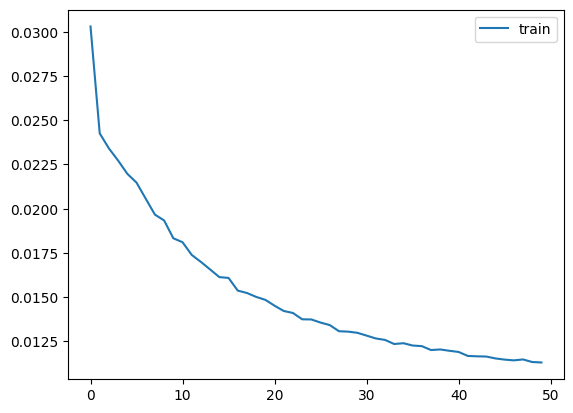

24/24 [==============================] - 1s 4ms/step
MAPE: 8.01981116332735
RMSE: 1442.4872070045417
Correlation 0.8009981619846911 with p-value 1.7141046533858382e-167


In [ ]:
run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=False, tan=True, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

### Huang

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/34dt57s5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/2yl4cq63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9729', 'data', 'file=/tmp/tmp_oge6qew/34dt57s5.json', 'init=/tmp/tmp_oge6qew/2yl4cq63.json', 'output', 'file=/tmp/tmp_oge6qew/prophet_modelocn8zn1n/prophet_model-20240530202136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['variableElectricityPrice-60days', 'fixedElectricityPrice-60days', 'loadConsumption-60days-24h', 'dailyMeanWindspeed-60days', 'dailyMeanTemperature-60days', 'sic-60days', 'loadConsumption-60days-7days', 'fixedGasPrice-60days', 'other-60days', 'nat-60days', 'nao-60days', 'variableGasPrice-60days', 'biomass-60days', 'windEnergy-60days', 'geopotential-60days', 'loadConsumption-60days', 'heatPumps-60days', 'dailyPrecipitation-60days', 'solarEnergy-60days']
['variableElectricityPrice-60days', 'fixedElectricityPrice-60days', 'loadConsumption-60days-24h', 'dailyMeanWindspeed-60days', 'dailyMeanTemperature-60days', 'sic-60days', 'loadConsumption-60days-7days', 'fixedGasPrice-60days', 'other-60days', 'nat-60days', 'nao-60days', 'variableGasPrice-60days', 'biomass-60days', 'windEnergy-60days', 'geopotential-60days', 'loadConsumption-60days', 'heatPumps-60days', 'dailyPrecipitation-60days', 'solarEnergy-60days', 'y', 'ds']
Epoch 1/50
94/94 - 4s - loss: 0.0919 - val_loss: 4.3502 - 4s/epoch - 46ms

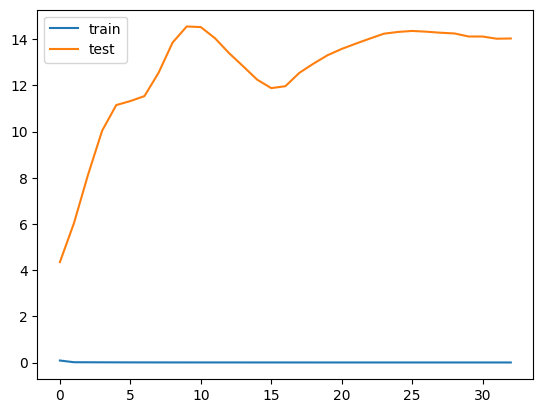

187/187 [==============================] - 1s 2ms/step
MAPE: 270.9310328480609
RMSE: 37757.01957322303
Correlation -0.472843614745995 with p-value 0.0
Epoch 1/50
187/187 - 5s - loss: 0.0487 - val_loss: 0.0600 - 5s/epoch - 29ms/step
Epoch 2/50
187/187 - 1s - loss: 0.0186 - val_loss: 0.0511 - 1s/epoch - 6ms/step
Epoch 3/50
187/187 - 1s - loss: 0.0162 - val_loss: 0.0425 - 1s/epoch - 6ms/step
Epoch 4/50
187/187 - 1s - loss: 0.0144 - val_loss: 0.0342 - 961ms/epoch - 5ms/step
Epoch 5/50
187/187 - 1s - loss: 0.0130 - val_loss: 0.0286 - 957ms/epoch - 5ms/step
Epoch 6/50
187/187 - 1s - loss: 0.0120 - val_loss: 0.0249 - 981ms/epoch - 5ms/step
Epoch 7/50
187/187 - 1s - loss: 0.0113 - val_loss: 0.0226 - 943ms/epoch - 5ms/step
Epoch 8/50
187/187 - 1s - loss: 0.0107 - val_loss: 0.0206 - 953ms/epoch - 5ms/step
Epoch 9/50
187/187 - 1s - loss: 0.0103 - val_loss: 0.0192 - 1s/epoch - 6ms/step
Epoch 10/50
187/187 - 1s - loss: 0.0101 - val_loss: 0.0191 - 1s/epoch - 6ms/step
Epoch 11/50
187/187 - 1s - loss:

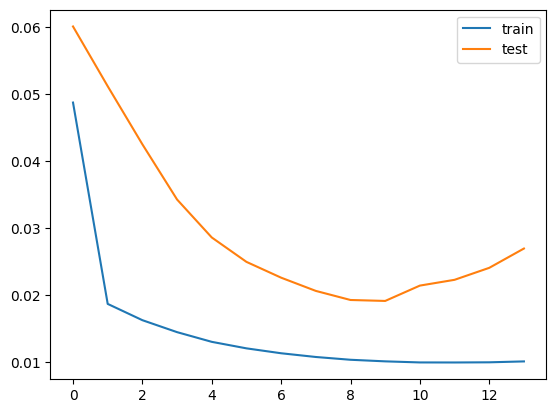

187/187 [==============================] - 1s 2ms/step
MAPE: 11.235979908212528
RMSE: 1737.7292485612763
Correlation 0.5601448531701301 with p-value 0.0
Epoch 1/50
281/281 - 4s - loss: 0.0413 - val_loss: 0.0434 - 4s/epoch - 14ms/step
Epoch 2/50
281/281 - 1s - loss: 0.0208 - val_loss: 0.0165 - 1s/epoch - 5ms/step
Epoch 3/50
281/281 - 1s - loss: 0.0165 - val_loss: 0.0185 - 1s/epoch - 5ms/step
Epoch 4/50
281/281 - 1s - loss: 0.0148 - val_loss: 0.0431 - 1s/epoch - 5ms/step
Epoch 5/50
281/281 - 2s - loss: 0.0135 - val_loss: 0.0684 - 2s/epoch - 8ms/step
Epoch 6/50
281/281 - 2s - loss: 0.0122 - val_loss: 0.0749 - 2s/epoch - 8ms/step
Epoch 7/50
281/281 - 1s - loss: 0.0112 - val_loss: 0.0531 - 1s/epoch - 5ms/step
Epoch 8/50
281/281 - 1s - loss: 0.0106 - val_loss: 0.0374 - 1s/epoch - 5ms/step
Epoch 9/50
281/281 - 1s - loss: 0.0103 - val_loss: 0.0283 - 1s/epoch - 5ms/step
Epoch 10/50
281/281 - 1s - loss: 0.0100 - val_loss: 0.0191 - 1s/epoch - 5ms/step
Epoch 11/50
281/281 - 1s - loss: 0.0099 - val

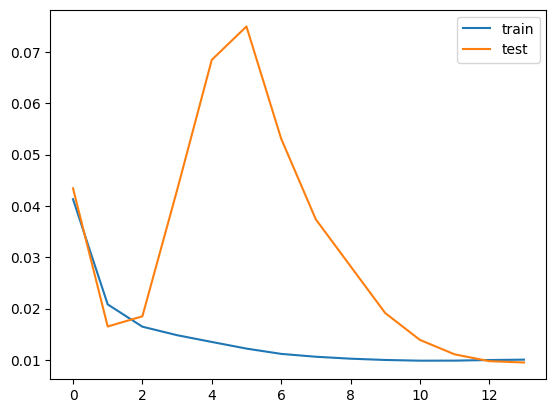

187/187 [==============================] - 1s 3ms/step
MAPE: 6.516433475606526
RMSE: 1036.5182202247754
Correlation 0.7900410164179814 with p-value 0.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=True,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False,
    include_price_bool=False,
    include_climate_change_bool=False

)



In [ ]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 13510.42234733636
avg corr 0.2924474182807055
avg mape 96.22781541062665


In [ ]:
for i in range(3):
  print(f"{i+1} & {rmse_list[i]} & {corrs[i]} & {mape_list[i]}" )

1 & 37757.01957322303 & -0.472843614745995 & 270.9310328480609
2 & 1737.7292485612763 & 0.5601448531701301 & 11.235979908212528
3 & 1036.5182202247754 & 0.7900410164179814 & 6.516433475606526


In [ ]:
run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

# Top n predictors

### Tan

[('sic-60days', {'corr': -0.24096749131625897, 'p_value': 3.8006092816e-313}), ('nao-60days', {'corr': -0.22877071195892829, 'p_value': 1.2705399980378403e-281}), ('biomass-60days', {'corr': 0.1840918474526652, 'p_value': 2.20502661249377e-181}), ('nat-60days', {'corr': 0.17567634724377243, 'p_value': 4.1486998532849005e-165}), ('geopotential-60days', {'corr': 0.16359319054392757, 'p_value': 3.770986756211954e-143}), ('solarEnergy-60days', {'corr': -0.11476744007094207, 'p_value': 5.928080428286119e-71}), ('windEnergy-60days', {'corr': -0.10834361602992665, 'p_value': 2.1727447807764325e-63}), ('heatPumps-60days', {'corr': -0.1062038470893567, 'p_value': 5.730883643781733e-61}), ('dailyMeanWindspeed-60days', {'corr': -0.06899700939477675, 'p_value': 1.2038326272521808e-26}), ('variableElectricityPrice-60days', {'corr': 0.04244724605509237, 'p_value': 5.0915712845175937e-11}), ('dailyPrecipitation-60days', {'corr': 0.03718069688854672, 'p_value': 8.783435602609277e-09}), ('fixedElectric

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/8dvtc_0a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/61b5xrly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31196', 'data', 'file=/tmp/tmp_oge6qew/8dvtc_0a.json', 'init=/tmp/tmp_oge6qew/61b5xrly.json', 'output', 'file=/tmp/tmp_oge6qew/prophet_modelucms9ttr/prophet_model-20240530202421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['sic-60days', 'nat-60days', 'geopotential-60days', 'nao-60days', 'loadConsumption-60days', 'loadConsumption-60days-7days', 'loadConsumption-60days-24h', 'biomass-60days']
['sic-60days', 'nat-60days', 'geopotential-60days', 'nao-60days', 'loadConsumption-60days', 'loadConsumption-60days-7days', 'loadConsumption-60days-24h', 'biomass-60days', 'y', 'ds']
Epoch 1/50
94/94 - 4s - loss: 0.0475 - val_loss: 0.0536 - 4s/epoch - 48ms/step
Epoch 2/50
94/94 - 1s - loss: 0.0244 - val_loss: 0.0554 - 549ms/epoch - 6ms/step
Epoch 3/50
94/94 - 1s - loss: 0.0234 - val_loss: 0.0501 - 679ms/epoch - 7ms/step
Epoch 4/50
94/94 - 1s - loss: 0.0227 - val_loss: 0.0514 - 552ms/epoch - 6ms/step
Epoch 5/50
94/94 - 1s - loss: 0.0221 - val_loss: 0.0490 - 683ms/epoch - 7ms/step
Epoch 6/50
94/94 - 1s - loss: 0.0216 - val_loss: 0.0497 - 712ms/epoch - 8ms/step
Epoch 7/50
94/94 - 1s - loss: 0.0215 - val_loss: 0.0502 - 520ms/epoch - 6ms/step
Epoch 8/50
94/94 - 1s - loss: 0.0214 - val_loss: 0.0476 - 518ms/epoch - 6ms/step

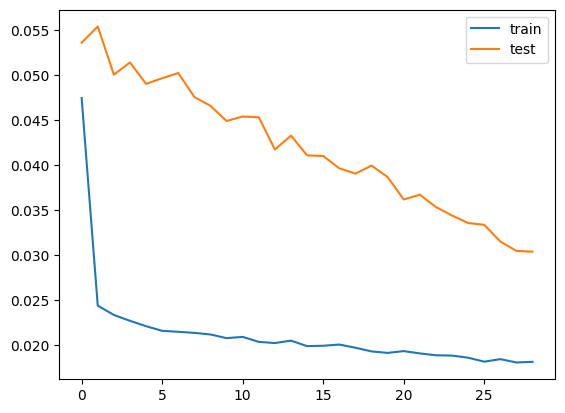

187/187 [==============================] - 1s 2ms/step
MAPE: 13.501011404864919
RMSE: 1757.7927541442743
Correlation 0.7672862112381165 with p-value 0.0
Epoch 1/50
187/187 - 7s - loss: 0.0341 - val_loss: 0.0383 - 7s/epoch - 36ms/step
Epoch 2/50
187/187 - 1s - loss: 0.0249 - val_loss: 0.0376 - 1s/epoch - 7ms/step
Epoch 3/50
187/187 - 1s - loss: 0.0244 - val_loss: 0.0376 - 1s/epoch - 6ms/step
Epoch 4/50
187/187 - 1s - loss: 0.0240 - val_loss: 0.0381 - 892ms/epoch - 5ms/step
Epoch 5/50
187/187 - 1s - loss: 0.0236 - val_loss: 0.0368 - 850ms/epoch - 5ms/step
Epoch 6/50
187/187 - 1s - loss: 0.0233 - val_loss: 0.0364 - 838ms/epoch - 4ms/step
Epoch 7/50
187/187 - 1s - loss: 0.0230 - val_loss: 0.0369 - 973ms/epoch - 5ms/step
Epoch 8/50
187/187 - 1s - loss: 0.0225 - val_loss: 0.0355 - 856ms/epoch - 5ms/step
Epoch 9/50
187/187 - 1s - loss: 0.0224 - val_loss: 0.0349 - 967ms/epoch - 5ms/step
Epoch 10/50
187/187 - 1s - loss: 0.0220 - val_loss: 0.0338 - 997ms/epoch - 5ms/step
Epoch 11/50
187/187 - 1s

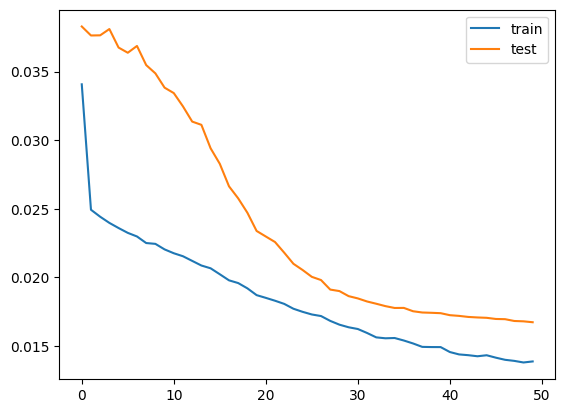

187/187 [==============================] - 1s 2ms/step
MAPE: 9.672802568551027
RMSE: 1370.5314043948756
Correlation 0.7072698386293875 with p-value 0.0
Epoch 1/50
281/281 - 6s - loss: 0.0310 - val_loss: 0.0414 - 6s/epoch - 21ms/step
Epoch 2/50
281/281 - 1s - loss: 0.0261 - val_loss: 0.0381 - 1s/epoch - 5ms/step
Epoch 3/50
281/281 - 1s - loss: 0.0250 - val_loss: 0.0360 - 1s/epoch - 5ms/step
Epoch 4/50
281/281 - 1s - loss: 0.0242 - val_loss: 0.0336 - 1s/epoch - 4ms/step
Epoch 5/50
281/281 - 1s - loss: 0.0237 - val_loss: 0.0320 - 1s/epoch - 5ms/step
Epoch 6/50
281/281 - 1s - loss: 0.0230 - val_loss: 0.0336 - 1s/epoch - 4ms/step
Epoch 7/50
281/281 - 1s - loss: 0.0226 - val_loss: 0.0292 - 1s/epoch - 5ms/step
Epoch 8/50
281/281 - 1s - loss: 0.0221 - val_loss: 0.0292 - 1s/epoch - 4ms/step
Epoch 9/50
281/281 - 1s - loss: 0.0214 - val_loss: 0.0281 - 1s/epoch - 4ms/step
Epoch 10/50
281/281 - 2s - loss: 0.0208 - val_loss: 0.0263 - 2s/epoch - 6ms/step
Epoch 11/50
281/281 - 2s - loss: 0.0202 - val_

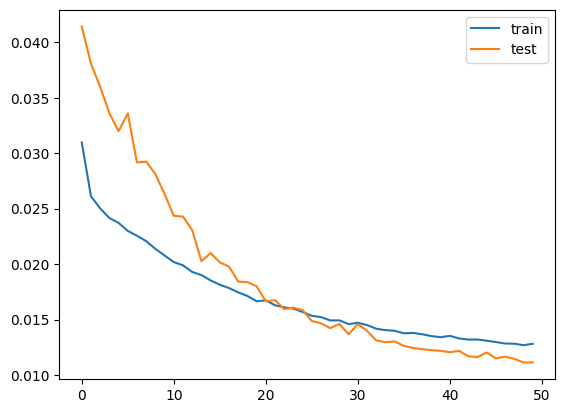

187/187 [==============================] - 1s 2ms/step
MAPE: 6.986821578677089
RMSE: 1121.1099825870679
Correlation 0.7823803528369984 with p-value 0.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=True,
    use_all_predictors=False,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=False,
    tan=True,
    include_price_bool=False,
    include_climate_change_bool=False
)

In [ ]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1416.4780470420726
avg corr 0.7523121342348341
avg mape 10.05354518403101


In [ ]:
for i in range(3):
  print(f"{i+1} & {rmse_list[i]} & {corrs[i]} & {mape_list[i]}" )

1 & 1757.7927541442743 & 0.7672862112381165 & 13.501011404864919
2 & 1370.5314043948756 & 0.7072698386293875 & 9.672802568551027
3 & 1121.1099825870679 & 0.7823803528369984 & 6.986821578677089


['NAO-60days', 'Biomassa-60days', 'geopotential-60days', 'LoadConsumption-60days-7days', 'nat-60days', 'LoadConsumption-60days', 'LoadConsumption-60days-24h', 'sic-60days']
['NAO-60days', 'Biomassa-60days', 'geopotential-60days', 'LoadConsumption-60days-7days', 'nat-60days', 'LoadConsumption-60days', 'LoadConsumption-60days-24h', 'sic-60days', 'y', 'ds']
23925 744
shape 1 9
Epoch 1/50
374/374 - 4s - loss: 0.0301 - 4s/epoch - 11ms/step
Epoch 2/50
374/374 - 1s - loss: 0.0245 - 1s/epoch - 4ms/step
Epoch 3/50
374/374 - 1s - loss: 0.0236 - 1s/epoch - 4ms/step
Epoch 4/50
374/374 - 1s - loss: 0.0231 - 1s/epoch - 4ms/step
Epoch 5/50
374/374 - 2s - loss: 0.0223 - 2s/epoch - 4ms/step
Epoch 6/50
374/374 - 2s - loss: 0.0216 - 2s/epoch - 5ms/step
Epoch 7/50
374/374 - 2s - loss: 0.0209 - 2s/epoch - 6ms/step
Epoch 8/50
374/374 - 1s - loss: 0.0200 - 1s/epoch - 4ms/step
Epoch 9/50
374/374 - 1s - loss: 0.0195 - 1s/epoch - 4ms/step
Epoch 10/50
374/374 - 1s - loss: 0.0186 - 1s/epoch - 4ms/step
Epoch 11/50

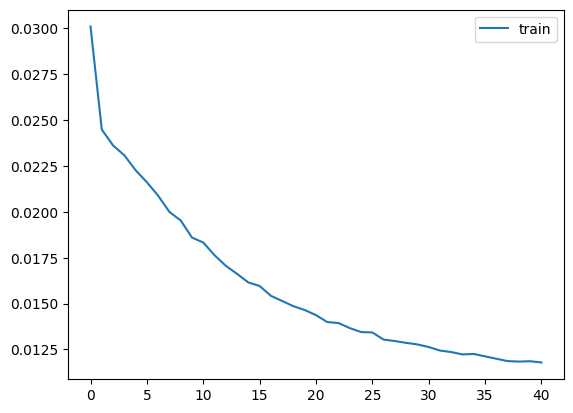

24/24 [==============================] - 1s 2ms/step
MAPE: 7.776343194986719
RMSE: 1399.0306141948738
Correlation 0.8192798964871952 with p-value 2.1134659592884388e-181


In [ ]:
run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=False, tan=True, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

### Huang

[('sic-60days', {'corr': -0.24096749131625897, 'p_value': 3.8006092816e-313}), ('nao-60days', {'corr': -0.22877071195892829, 'p_value': 1.2705399980378403e-281}), ('biomass-60days', {'corr': 0.1840918474526652, 'p_value': 2.20502661249377e-181}), ('nat-60days', {'corr': 0.17567634724377243, 'p_value': 4.1486998532849005e-165}), ('geopotential-60days', {'corr': 0.16359319054392757, 'p_value': 3.770986756211954e-143}), ('solarEnergy-60days', {'corr': -0.11476744007094207, 'p_value': 5.928080428286119e-71}), ('windEnergy-60days', {'corr': -0.10834361602992665, 'p_value': 2.1727447807764325e-63}), ('heatPumps-60days', {'corr': -0.1062038470893567, 'p_value': 5.730883643781733e-61}), ('dailyMeanWindspeed-60days', {'corr': -0.06899700939477675, 'p_value': 1.2038326272521808e-26}), ('variableElectricityPrice-60days', {'corr': 0.04244724605509237, 'p_value': 5.0915712845175937e-11}), ('dailyPrecipitation-60days', {'corr': 0.03718069688854672, 'p_value': 8.783435602609277e-09}), ('fixedElectric

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/7ofelhv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/3c5h_2r4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6059', 'data', 'file=/tmp/tmp_oge6qew/7ofelhv9.json', 'init=/tmp/tmp_oge6qew/3c5h_2r4.json', 'output', 'file=/tmp/tmp_oge6qew/prophet_model2whitax6/prophet_model-20240530202832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['sic-60days', 'nat-60days', 'geopotential-60days', 'nao-60days', 'loadConsumption-60days', 'loadConsumption-60days-7days', 'loadConsumption-60days-24h', 'biomass-60days']
['sic-60days', 'nat-60days', 'geopotential-60days', 'nao-60days', 'loadConsumption-60days', 'loadConsumption-60days-7days', 'loadConsumption-60days-24h', 'biomass-60days', 'y', 'ds']
Epoch 1/50
94/94 - 5s - loss: 0.0890 - val_loss: 0.0531 - 5s/epoch - 51ms/step
Epoch 2/50
94/94 - 1s - loss: 0.0187 - val_loss: 0.0354 - 1s/epoch - 11ms/step
Epoch 3/50
94/94 - 1s - loss: 0.0162 - val_loss: 0.0222 - 782ms/epoch - 8ms/step
Epoch 4/50
94/94 - 1s - loss: 0.0136 - val_loss: 0.0167 - 604ms/epoch - 6ms/step
Epoch 5/50
94/94 - 1s - loss: 0.0116 - val_loss: 0.0170 - 581ms/epoch - 6ms/step
Epoch 6/50
94/94 - 1s - loss: 0.0105 - val_loss: 0.0203 - 726ms/epoch - 8ms/step
Epoch 7/50
94/94 - 1s - loss: 0.0100 - val_loss: 0.0242 - 705ms/epoch - 7ms/step
Epoch 8/50
94/94 - 1s - loss: 0.0100 - val_loss: 0.0273 - 620ms/epoch - 7ms/step
E

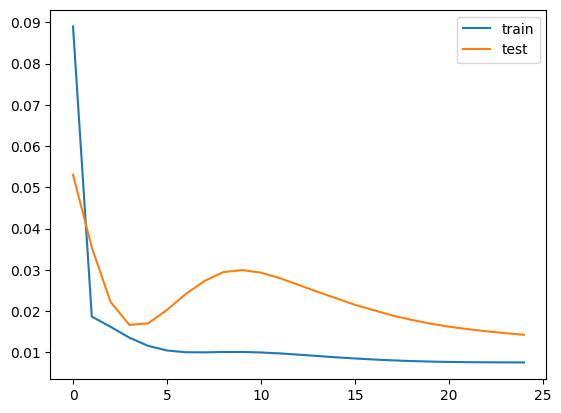

187/187 [==============================] - 1s 2ms/step
MAPE: 8.569052261839232
RMSE: 1204.5366565993706
Correlation 0.8216543763826206 with p-value 0.0
Epoch 1/50
187/187 - 6s - loss: 0.0510 - val_loss: 0.0399 - 6s/epoch - 30ms/step
Epoch 2/50
187/187 - 1s - loss: 0.0165 - val_loss: 0.0329 - 1s/epoch - 7ms/step
Epoch 3/50
187/187 - 2s - loss: 0.0144 - val_loss: 0.0261 - 2s/epoch - 11ms/step
Epoch 4/50
187/187 - 2s - loss: 0.0122 - val_loss: 0.0201 - 2s/epoch - 9ms/step
Epoch 5/50
187/187 - 1s - loss: 0.0107 - val_loss: 0.0161 - 1s/epoch - 7ms/step
Epoch 6/50
187/187 - 1s - loss: 0.0099 - val_loss: 0.0143 - 1s/epoch - 6ms/step
Epoch 7/50
187/187 - 1s - loss: 0.0097 - val_loss: 0.0137 - 1s/epoch - 5ms/step
Epoch 8/50
187/187 - 1s - loss: 0.0096 - val_loss: 0.0135 - 1s/epoch - 6ms/step
Epoch 9/50
187/187 - 1s - loss: 0.0096 - val_loss: 0.0134 - 1s/epoch - 6ms/step
Epoch 10/50
187/187 - 1s - loss: 0.0096 - val_loss: 0.0131 - 1s/epoch - 6ms/step
Epoch 11/50
187/187 - 1s - loss: 0.0096 - val

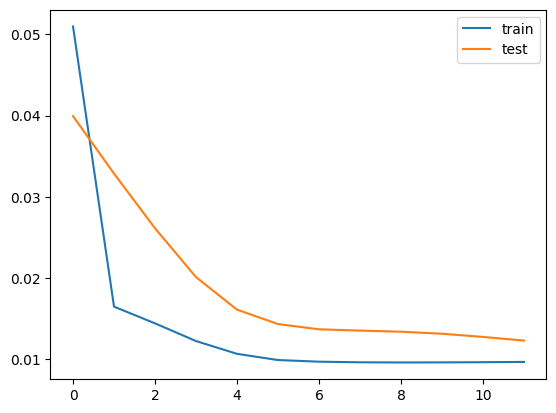

187/187 [==============================] - 1s 2ms/step
MAPE: 8.091455577020906
RMSE: 1174.1681661067896
Correlation 0.7967746482399388 with p-value 0.0
Epoch 1/50
281/281 - 6s - loss: 0.0430 - val_loss: 0.0274 - 6s/epoch - 21ms/step
Epoch 2/50
281/281 - 1s - loss: 0.0144 - val_loss: 0.0214 - 1s/epoch - 5ms/step
Epoch 3/50
281/281 - 2s - loss: 0.0117 - val_loss: 0.0146 - 2s/epoch - 5ms/step
Epoch 4/50
281/281 - 2s - loss: 0.0105 - val_loss: 0.0135 - 2s/epoch - 5ms/step
Epoch 5/50
281/281 - 1s - loss: 0.0102 - val_loss: 0.0150 - 1s/epoch - 5ms/step
Epoch 6/50
281/281 - 1s - loss: 0.0101 - val_loss: 0.0170 - 1s/epoch - 5ms/step
Epoch 7/50
281/281 - 1s - loss: 0.0101 - val_loss: 0.0187 - 1s/epoch - 5ms/step
Epoch 8/50
281/281 - 2s - loss: 0.0101 - val_loss: 0.0202 - 2s/epoch - 8ms/step
Epoch 9/50
281/281 - 2s - loss: 0.0101 - val_loss: 0.0209 - 2s/epoch - 8ms/step
Epoch 10/50
281/281 - 2s - loss: 0.0100 - val_loss: 0.0216 - 2s/epoch - 6ms/step
Epoch 11/50
281/281 - 1s - loss: 0.0100 - val_

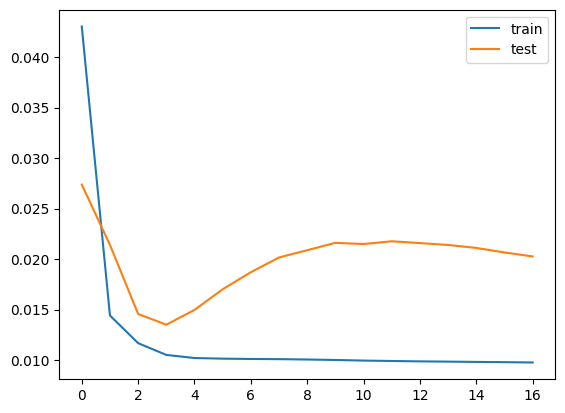

187/187 [==============================] - 1s 3ms/step
MAPE: 9.120152121207852
RMSE: 1512.4821447503616
Correlation 0.659612486419299 with p-value 0.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=True,
    use_all_predictors=False,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False,
    include_price_bool=False,
    include_climate_change_bool=False
)

In [ ]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1297.0623224855074
avg corr 0.7593471703472862
avg mape 8.593553320022663


In [ ]:
for i in range(3):
  print(f"{i+1} & {rmse_list[i]} & {corrs[i]} & {mape_list[i]}" )

1 & 1204.5366565993706 & 0.8216543763826206 & 8.569052261839232
2 & 1174.1681661067896 & 0.7967746482399388 & 8.091455577020906
3 & 1512.4821447503616 & 0.659612486419299 & 9.120152121207852


['loadConsumption-60days-24h', 'nat-60days', 'loadConsumption-60days-7days', 'biomass-60days', 'sic-60days', 'loadConsumption-60days', 'nao-60days', 'geopotential-60days']
['loadConsumption-60days-24h', 'nat-60days', 'loadConsumption-60days-7days', 'biomass-60days', 'sic-60days', 'loadConsumption-60days', 'nao-60days', 'geopotential-60days', 'y', 'ds']
23925 744
shape 1 9
Epoch 1/50
374/374 - 4s - loss: 0.0354 - 4s/epoch - 11ms/step
Epoch 2/50
374/374 - 2s - loss: 0.0149 - 2s/epoch - 5ms/step
Epoch 3/50
374/374 - 3s - loss: 0.0116 - 3s/epoch - 7ms/step
Epoch 4/50
374/374 - 2s - loss: 0.0101 - 2s/epoch - 5ms/step
Epoch 5/50
374/374 - 1s - loss: 0.0097 - 1s/epoch - 4ms/step
Epoch 6/50
374/374 - 1s - loss: 0.0094 - 1s/epoch - 4ms/step
Epoch 7/50
374/374 - 2s - loss: 0.0093 - 2s/epoch - 4ms/step
Epoch 8/50
374/374 - 1s - loss: 0.0092 - 1s/epoch - 4ms/step
Epoch 9/50
374/374 - 1s - loss: 0.0092 - 1s/epoch - 4ms/step
Epoch 10/50
374/374 - 1s - loss: 0.0092 - 1s/epoch - 4ms/step
Epoch 11/50
3

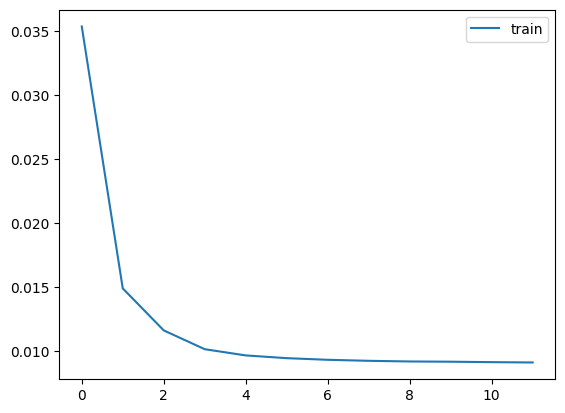

24/24 [==============================] - 0s 2ms/step
MAPE: 7.22419474940735
RMSE: 1291.6380062576152
Correlation 0.8377939952653045 with p-value 3.405338628009526e-197


In [ ]:
run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

# No predictors

### Tan

No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/em45uhf4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_oge6qew/bopbhhh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12536', 'data', 'file=/tmp/tmp_oge6qew/em45uhf4.json', 'init=/tmp/tmp_oge6qew/bopbhhh7.json', 'output', 'file=/tmp/tmp_oge6qew/prophet_modelib8_j4rn/prophet_model-20240530203052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:30:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['loadConsumption-60days', 'loadConsumption-60days-24h', 'loadConsumption-60days-7days']
['loadConsumption-60days', 'loadConsumption-60days-24h', 'loadConsumption-60days-7days', 'y', 'ds']
Epoch 1/50
94/94 - 4s - loss: 0.0405 - val_loss: 0.0557 - 4s/epoch - 46ms/step
Epoch 2/50
94/94 - 1s - loss: 0.0242 - val_loss: 0.0579 - 866ms/epoch - 9ms/step
Epoch 3/50
94/94 - 1s - loss: 0.0232 - val_loss: 0.0519 - 847ms/epoch - 9ms/step
Epoch 4/50
94/94 - 1s - loss: 0.0224 - val_loss: 0.0551 - 793ms/epoch - 8ms/step
Epoch 5/50
94/94 - 1s - loss: 0.0222 - val_loss: 0.0533 - 819ms/epoch - 9ms/step
Epoch 6/50
94/94 - 1s - loss: 0.0217 - val_loss: 0.0530 - 843ms/epoch - 9ms/step
Epoch 7/50
94/94 - 1s - loss: 0.0216 - val_loss: 0.0543 - 672ms/epoch - 7ms/step
Epoch 8/50
94/94 - 1s - loss: 0.0213 - val_loss: 0.0527 - 670ms/epoch - 7ms/step
Epoch 9/50
94/94 - 1s - loss: 0.0212 - val_loss: 0.0511 - 547ms/epoch - 6ms/step
Epoch 10/50
94/94 - 1s - loss: 0.0208 - val_loss: 0.0495 - 676ms/epoch - 7ms/step
Ep

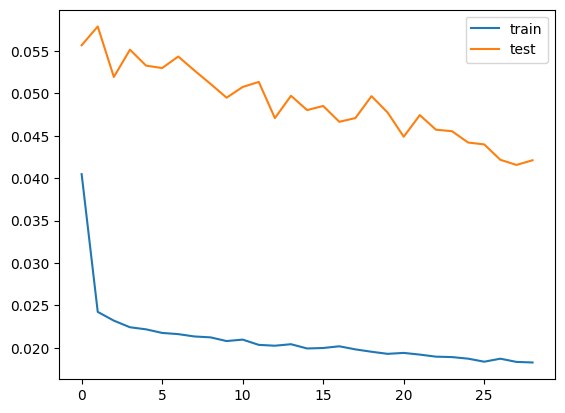

187/187 [==============================] - 1s 2ms/step
MAPE: 16.508413370031885
RMSE: 2068.805186872122
Correlation 0.8107514233409813 with p-value 0.0
Epoch 1/50
187/187 - 4s - loss: 0.0316 - val_loss: 0.0382 - 4s/epoch - 23ms/step
Epoch 2/50
187/187 - 1s - loss: 0.0252 - val_loss: 0.0382 - 983ms/epoch - 5ms/step
Epoch 3/50
187/187 - 1s - loss: 0.0244 - val_loss: 0.0376 - 857ms/epoch - 5ms/step
Epoch 4/50
187/187 - 1s - loss: 0.0240 - val_loss: 0.0387 - 1s/epoch - 6ms/step
Epoch 5/50
187/187 - 1s - loss: 0.0237 - val_loss: 0.0370 - 1s/epoch - 7ms/step
Epoch 6/50
187/187 - 1s - loss: 0.0232 - val_loss: 0.0369 - 1s/epoch - 7ms/step
Epoch 7/50
187/187 - 1s - loss: 0.0230 - val_loss: 0.0372 - 1s/epoch - 8ms/step
Epoch 8/50
187/187 - 1s - loss: 0.0225 - val_loss: 0.0363 - 951ms/epoch - 5ms/step
Epoch 9/50
187/187 - 1s - loss: 0.0225 - val_loss: 0.0359 - 940ms/epoch - 5ms/step
Epoch 10/50
187/187 - 1s - loss: 0.0221 - val_loss: 0.0351 - 1s/epoch - 7ms/step
Epoch 11/50
187/187 - 1s - loss: 0

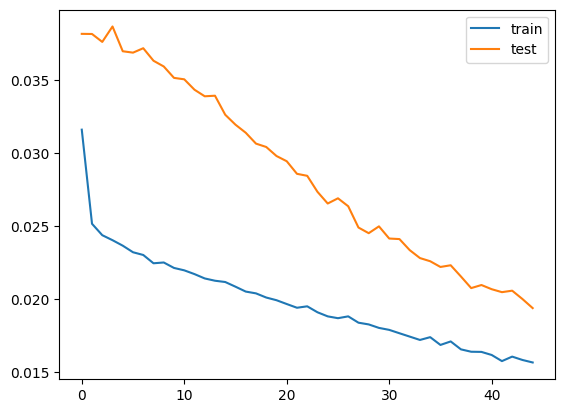

187/187 [==============================] - 1s 2ms/step
MAPE: 9.651357410472308
RMSE: 1475.0193990172904
Correlation 0.8035736766044059 with p-value 0.0
Epoch 1/50
281/281 - 6s - loss: 0.0326 - val_loss: 0.0392 - 6s/epoch - 23ms/step
Epoch 2/50
281/281 - 1s - loss: 0.0258 - val_loss: 0.0384 - 1s/epoch - 5ms/step
Epoch 3/50
281/281 - 1s - loss: 0.0250 - val_loss: 0.0369 - 1s/epoch - 5ms/step
Epoch 4/50
281/281 - 1s - loss: 0.0243 - val_loss: 0.0362 - 1s/epoch - 5ms/step
Epoch 5/50
281/281 - 1s - loss: 0.0241 - val_loss: 0.0352 - 1s/epoch - 5ms/step
Epoch 6/50
281/281 - 1s - loss: 0.0234 - val_loss: 0.0369 - 1s/epoch - 5ms/step
Epoch 7/50
281/281 - 1s - loss: 0.0231 - val_loss: 0.0339 - 1s/epoch - 4ms/step
Epoch 8/50
281/281 - 1s - loss: 0.0227 - val_loss: 0.0345 - 1s/epoch - 5ms/step
Epoch 9/50
281/281 - 2s - loss: 0.0221 - val_loss: 0.0344 - 2s/epoch - 5ms/step
Epoch 10/50
281/281 - 2s - loss: 0.0217 - val_loss: 0.0335 - 2s/epoch - 7ms/step
Epoch 11/50
281/281 - 2s - loss: 0.0212 - val_

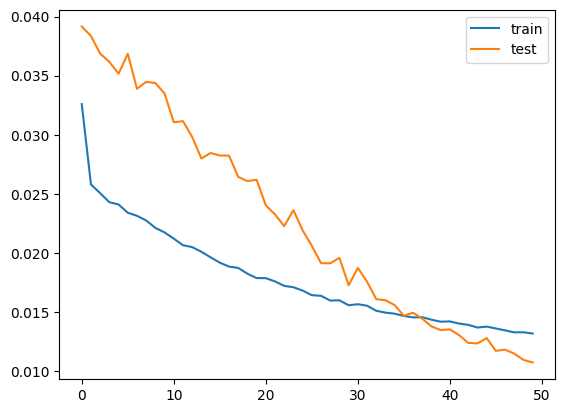

187/187 [==============================] - 1s 3ms/step
MAPE: 6.458933405648128
RMSE: 1100.257960746633
Correlation 0.8139882098115474 with p-value 0.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=False,
    use_no_predictors=True,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=False,
    tan=True,
    include_price_bool=False,
    include_climate_change_bool=False
)

In [ ]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1548.0275155453485
avg corr 0.8094377699189782
avg mape 10.872901395384106


In [ ]:
for i in range(3):
  print(f"{i+1} & {rmse_list[i]} & {corrs[i]} & {mape_list[i]}" )

1 & 2068.805186872122 & 0.8107514233409813 & 16.508413370031885
2 & 1475.0193990172904 & 0.8035736766044059 & 9.651357410472308
3 & 1100.257960746633 & 0.8139882098115474 & 6.458933405648128


['LoadConsumption-60days', 'LoadConsumption-60days-7days', 'LoadConsumption-60days-24h']
['LoadConsumption-60days', 'LoadConsumption-60days-7days', 'LoadConsumption-60days-24h', 'y', 'ds']
23925 744
shape 1 4
Epoch 1/50
374/374 - 5s - loss: 0.0290 - 5s/epoch - 13ms/step
Epoch 2/50
374/374 - 1s - loss: 0.0243 - 1s/epoch - 4ms/step
Epoch 3/50
374/374 - 1s - loss: 0.0236 - 1s/epoch - 4ms/step
Epoch 4/50
374/374 - 1s - loss: 0.0232 - 1s/epoch - 4ms/step
Epoch 5/50
374/374 - 1s - loss: 0.0226 - 1s/epoch - 4ms/step
Epoch 6/50
374/374 - 1s - loss: 0.0224 - 1s/epoch - 4ms/step
Epoch 7/50
374/374 - 1s - loss: 0.0219 - 1s/epoch - 4ms/step
Epoch 8/50
374/374 - 2s - loss: 0.0214 - 2s/epoch - 5ms/step
Epoch 9/50
374/374 - 2s - loss: 0.0212 - 2s/epoch - 5ms/step
Epoch 10/50
374/374 - 2s - loss: 0.0204 - 2s/epoch - 4ms/step
Epoch 11/50
374/374 - 1s - loss: 0.0202 - 1s/epoch - 4ms/step
Epoch 12/50
374/374 - 1s - loss: 0.0195 - 1s/epoch - 4ms/step
Epoch 13/50
374/374 - 1s - loss: 0.0189 - 1s/epoch - 4m

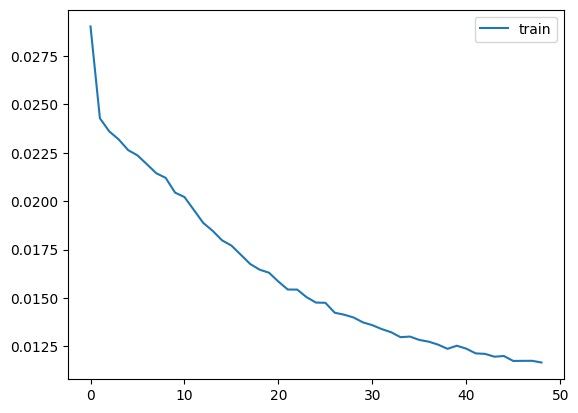

24/24 [==============================] - 1s 2ms/step
MAPE: 7.988494757295844
RMSE: 1443.7988318623525
Correlation 0.8205376507282042 with p-value 2.0436124701104538e-182


In [ ]:
run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=False, tan=True, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

### Huang

No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ewdachs/na80w9ce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ewdachs/jby_85cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27366', 'data', 'file=/tmp/tmp7ewdachs/na80w9ce.json', 'init=/tmp/tmp7ewdachs/jby_85cy.json', 'output', 'file=/tmp/tmp7ewdachs/prophet_modelxn91_s3r/prophet_model-20240529180105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['loadConsumption-60days-7days', 'loadConsumption-60days', 'loadConsumption-60days-24h']
['loadConsumption-60days-7days', 'loadConsumption-60days', 'loadConsumption-60days-24h', 'y', 'ds']
Epoch 1/50
94/94 - 4s - loss: 0.1102 - val_loss: 0.0430 - 4s/epoch - 44ms/step
Epoch 2/50
94/94 - 1s - loss: 0.0219 - val_loss: 0.0285 - 1s/epoch - 11ms/step
Epoch 3/50
94/94 - 1s - loss: 0.0190 - val_loss: 0.0252 - 972ms/epoch - 10ms/step
Epoch 4/50
94/94 - 1s - loss: 0.0172 - val_loss: 0.0232 - 970ms/epoch - 10ms/step
Epoch 5/50
94/94 - 2s - loss: 0.0157 - val_loss: 0.0214 - 2s/epoch - 20ms/step
Epoch 6/50
94/94 - 2s - loss: 0.0136 - val_loss: 0.0197 - 2s/epoch - 21ms/step
Epoch 7/50
94/94 - 2s - loss: 0.0122 - val_loss: 0.0178 - 2s/epoch - 21ms/step
Epoch 8/50
94/94 - 2s - loss: 0.0107 - val_loss: 0.0161 - 2s/epoch - 17ms/step
Epoch 9/50
94/94 - 1s - loss: 0.0093 - val_loss: 0.0147 - 1s/epoch - 15ms/step
Epoch 10/50
94/94 - 1s - loss: 0.0083 - val_loss: 0.0133 - 1s/epoch - 11ms/step
Epoch 11/50
94

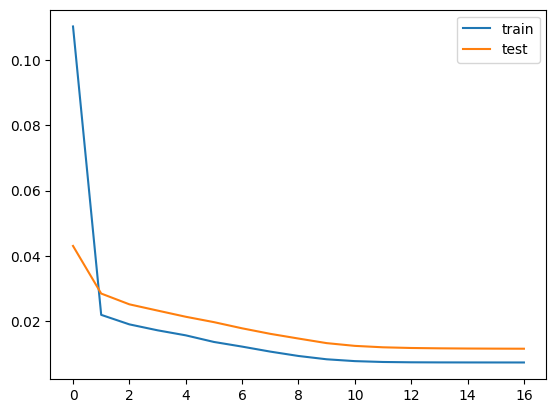

561/561 [==============================] - 1s 2ms/step
MAPE: 7.50798520719298
RMSE: 1084.2697333560548
Correlation 0.8251761003237543 with p-value 0.0
Epoch 1/50
187/187 - 4s - loss: 0.0577 - val_loss: 0.0260 - 4s/epoch - 23ms/step
Epoch 2/50
187/187 - 1s - loss: 0.0146 - val_loss: 0.0216 - 1s/epoch - 6ms/step
Epoch 3/50
187/187 - 2s - loss: 0.0128 - val_loss: 0.0180 - 2s/epoch - 10ms/step
Epoch 4/50
187/187 - 2s - loss: 0.0113 - val_loss: 0.0150 - 2s/epoch - 11ms/step
Epoch 5/50
187/187 - 1s - loss: 0.0102 - val_loss: 0.0128 - 1s/epoch - 7ms/step
Epoch 6/50
187/187 - 1s - loss: 0.0096 - val_loss: 0.0116 - 1s/epoch - 7ms/step
Epoch 7/50
187/187 - 1s - loss: 0.0094 - val_loss: 0.0111 - 1s/epoch - 7ms/step
Epoch 8/50
187/187 - 1s - loss: 0.0094 - val_loss: 0.0108 - 1s/epoch - 7ms/step
Epoch 9/50
187/187 - 1s - loss: 0.0094 - val_loss: 0.0108 - 1s/epoch - 6ms/step
Epoch 10/50
187/187 - 1s - loss: 0.0093 - val_loss: 0.0107 - 1s/epoch - 7ms/step
Epoch 11/50
187/187 - 1s - loss: 0.0093 - val

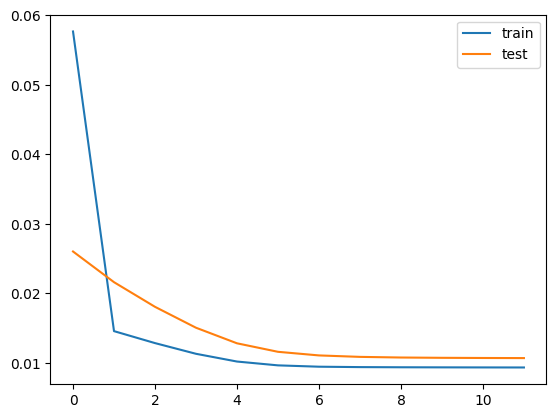

374/374 [==============================] - 1s 2ms/step
MAPE: 7.03105938787402
RMSE: 1094.5268985303042
Correlation 0.828267034699558 with p-value 0.0
Epoch 1/50
281/281 - 5s - loss: 0.0462 - val_loss: 0.0227 - 5s/epoch - 16ms/step
Epoch 2/50
281/281 - 1s - loss: 0.0141 - val_loss: 0.0148 - 1s/epoch - 5ms/step
Epoch 3/50
281/281 - 1s - loss: 0.0116 - val_loss: 0.0097 - 1s/epoch - 5ms/step
Epoch 4/50
281/281 - 2s - loss: 0.0100 - val_loss: 0.0081 - 2s/epoch - 7ms/step
Epoch 5/50
281/281 - 3s - loss: 0.0096 - val_loss: 0.0080 - 3s/epoch - 9ms/step
Epoch 6/50
281/281 - 1s - loss: 0.0096 - val_loss: 0.0081 - 1s/epoch - 5ms/step
Epoch 7/50
281/281 - 1s - loss: 0.0096 - val_loss: 0.0082 - 1s/epoch - 5ms/step
Epoch 8/50
281/281 - 1s - loss: 0.0096 - val_loss: 0.0082 - 1s/epoch - 5ms/step
Epoch 9/50
281/281 - 1s - loss: 0.0096 - val_loss: 0.0082 - 1s/epoch - 5ms/step
Epoch 10/50
281/281 - 2s - loss: 0.0096 - val_loss: 0.0082 - 2s/epoch - 5ms/step
Epoch 11/50
281/281 - 2s - loss: 0.0096 - val_lo

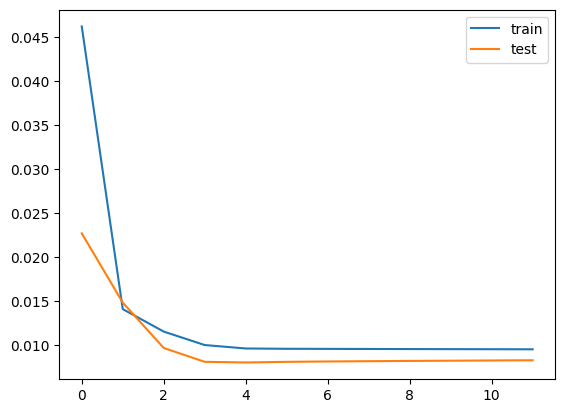

187/187 [==============================] - 1s 3ms/step
MAPE: 5.99611299072104
RMSE: 968.0379751445545
Correlation 0.8130122772329557 with p-value 0.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=False,
    use_no_predictors=True,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False,
    include_price_bool=False,
    include_climate_change_bool=False
)

In [ ]:
avg_rmse = sum(rmse_list) / len(rmse_list)
print(f'avg rmse {avg_rmse}')

corrs = [i[0] for i in corr_list]
avg_corr = sum(corrs) / len(corrs)
print(f'avg corr {avg_corr}')

avg_mape = sum(mape_list) / len(mape_list)
print(f'avg mape {avg_mape}')

avg rmse 1048.8775957033815
avg corr 0.8229935667227694
avg mape 6.842678693327088


In [ ]:
for i in range(3):
  print(f"{i+1} & {rmse_list[i]} & {corrs[i]} & {mape_list[i]}" )

1 & 1082.7923934860844 & 0.8262989983293736 & 7.496859412915026
2 & 1092.832374637645 & 0.8283886875212595 & 7.023676403350028
3 & 971.0080189864159 & 0.8142930143176746 & 6.007500263716208


['LoadConsumption-60days', 'LoadConsumption-60days-7days', 'LoadConsumption-60days-24h']
['LoadConsumption-60days', 'LoadConsumption-60days-7days', 'LoadConsumption-60days-24h', 'y', 'ds']
23925 744
shape 1 4
Epoch 1/50
374/374 - 4s - loss: 0.0374 - 4s/epoch - 10ms/step
Epoch 2/50
374/374 - 1s - loss: 0.0116 - 1s/epoch - 4ms/step
Epoch 3/50
374/374 - 1s - loss: 0.0095 - 1s/epoch - 4ms/step
Epoch 4/50
374/374 - 1s - loss: 0.0091 - 1s/epoch - 4ms/step
Epoch 5/50
374/374 - 1s - loss: 0.0091 - 1s/epoch - 4ms/step
Epoch 6/50
374/374 - 2s - loss: 0.0091 - 2s/epoch - 5ms/step
Epoch 7/50
374/374 - 2s - loss: 0.0091 - 2s/epoch - 7ms/step
Epoch 8/50
374/374 - 2s - loss: 0.0091 - 2s/epoch - 5ms/step
Epoch 9/50
374/374 - 1s - loss: 0.0091 - 1s/epoch - 4ms/step
Epoch 10/50
374/374 - 1s - loss: 0.0091 - 1s/epoch - 4ms/step
Epoch 11/50
374/374 - 1s - loss: 0.0091 - 1s/epoch - 4ms/step
Epoch 12/50
374/374 - 1s - loss: 0.0091 - 1s/epoch - 4ms/step


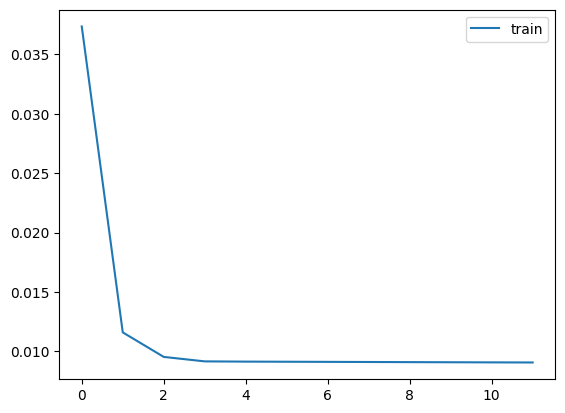

24/24 [==============================] - 0s 2ms/step
MAPE: 7.549319258358985
RMSE: 1356.0241114943055
Correlation 0.8302428293262959 with p-value 1.5998984753363439e-190


In [ ]:
# df_lstm.reset_index(inplace=True)
run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

for train_idx, test_idx in tscv.split(df_lstm):
  end_train_idx, start_test_idx = train_idx.max(), test_idx.min()

  n_train_samples = train_idx.max()
  n_validation_samples = test_idx.max() - test_idx.min()


  print(train_idx, test_idx)
  print(train_idx.max(), test_idx.min())
  # print(len(train_idx), len(test_idx))
  total_nr_samples = len(train_idx) + len(test_idx)
  print(len(train_idx)/total_nr_samples*100, len(test_idx)/total_nr_samples*100)

[   0    1    2 ... 5979 5980 5981] [ 5982  5983  5984 ... 11960 11961 11962]
5981 5982
50.00417955362367 49.99582044637633
[    0     1     2 ... 11960 11961 11962] [11963 11964 11965 ... 17941 17942 17943]
11962 11963
66.66852429781542 33.33147570218458
[    0     1     2 ... 17941 17942 17943] [17944 17945 17946 ... 23922 23923 23924]
17943 17944
75.00104493207942 24.998955067920587


# Visualization of model

In [ ]:
!pip install visualkeras

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
model.add(LSTM(30, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
model.add(LSTM(60, activation='tanh', name='LSTM_Layer_2'))
model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
model.add(Dense(1, activation='linear', name='Dense_Layer'))
model.compile(optimizer='rmsprop', loss='mse')

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


NameError: name 'plot_model' is not defined

In [ ]:
# from tensorflow.keras.utils import plot_model

# model = Sequential()
# model.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), name='LSTM1'))
# model.add(LSTM(90, activation='relu', name='LSTM2'))
# model.add(Dense(1, name='Dense'))
# model.compile(optimizer='adam', loss='mse')

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# # plot_model(model, show_shapes=True, show_layer_names=True) # to_file='/content/drive/MyDrive/master_thesis_data/preprocessed_data.csv.png',



# MLR

### All predictors

In [ ]:
df = read_processed_data(include_price_bool=True)
# df_flagged = create_national_holiday_and_event_flag(df)
# df = encode_string_columns(df)

numerical_columns = find_numerical_columns(df)

df_flagged_outliers_cleared = clear_outliers(df, numerical_columns=['loadConsumption'], start_winter=start_test_wintertime)

df_lag = shift_data(df_flagged_outliers_cleared, n_days_lag)

(df_test, df_train_val) = split_train_val_test(df_lag, start_test_wintertime)

(df_train_val, df_test, numerical_columns_lagged) = impute_numerical_columns(df_train_val, df_test, numerical_columns, n_days_lag)

df_train_val.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(df_train_val)
df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

df_test = df_test[df_train_val.columns]
test_scaled = scaler.transform(df_test)
df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

# reorder columns
cols_ordered = list(df_train_scaled)
cols_ordered.remove('loadConsumption_scaled')
cols_ordered.append('loadConsumption_scaled')
df_train_scaled = df_train_scaled[cols_ordered]
df_test_scaled = df_test_scaled[cols_ordered]

# split into X and y
train_values = df_train_scaled.values
test_values = df_test_scaled.values

train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]


In [ ]:
df_train_scaled

,dailyPrecipitation-60days_scaled,dailyMeanTemperature-60days_scaled,dailyMeanWindspeed-60days_scaled,nao-60days_scaled,biomass-60days_scaled,windEnergy-60days_scaled,solarEnergy-60days_scaled,heatPumps-60days_scaled,other-60days_scaled,fixedGasPrice-60days_scaled,variableGasPrice-60days_scaled,fixedElectricityPrice-60days_scaled,variableElectricityPrice-60days_scaled,nat-60days_scaled,sic-60days_scaled,geopotential-60days_scaled,loadConsumption-60days_scaled,loadConsumption-60days-24h_scaled,loadConsumption-60days-7days_scaled,loadConsumption_scaled
0,0.011655,0.211009,0.061728,0.297229,0.399524,0.00000,0.000000,0.000000,0.0,0.235351,0.001685,0.158273,0.000890,0.372351,0.924510,0.031365,0.483369,0.492058,0.445878,0.401833
1,0.011655,0.211009,0.061728,0.297229,0.399524,0.00000,0.000000,0.000000,0.0,0.235351,0.001685,0.158273,0.000890,0.372351,0.924510,0.031365,0.460738,0.469785,0.409641,0.399359
2,0.011655,0.211009,0.061728,0.297229,0.399524,0.00000,0.000000,0.000000,0.0,0.235351,0.001685,0.158273,0.000890,0.372351,0.924510,0.031365,0.455221,0.459669,0.377109,0.401912
3,0.011655,0.211009,0.061728,0.297229,0.399524,0.00000,0.000000,0.000000,0.0,0.235351,0.001685,0.158273,0.000890,0.372351,0.924510,0.031365,0.464569,0.466864,0.357897,0.403637
4,0.011655,0.211009,0.061728,0.297229,0.399524,0.00000,0.000000,0.000000,0.0,0.235351,0.001685,0.158273,0.000890,0.372351,0.924510,0.031365,0.504084,0.506437,0.362482,0.436666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23920,0.002331,0.715596,0.259259,0.065491,1.000000,0.82967,0.790105,0.842857,1.0,0.970221,0.224127,1.000000,0.281549,0.711071,0.293525,0.650956,0.574266,0.533662,0.542645,0.888396
23921,0.002331,0.715596,0.259259,0.065491,1.000000,0.82967,0.790105,0.842857,1.0,0.970221,0.224127,1.000000,0.281549,0.711071,0.293525,0.650956,0.522495,0.469946,0.463312,0.823738
23922,0.002331,0.715596,0.259259,0.065491,1.000000,0.82967,0.790105,0.842857,1.0,0.970221,0.224127,1.000000,0.281549,0.711071,0.293525,0.650956,0.460704,0.359139,0.425496,0.761217
23923,0.002331,0.715596,0.259259,0.065491,1.000000,0.82967,0.790105,0.842857,1.0,0.970221,0.224127,1.000000,0.281549,0.711071,0.293525,0.650956,0.374296,0.308122,0.400106,0.706149


In [ ]:
train_X

array([[0.01165501, 0.21100917, 0.0617284 , ..., 0.48336935, 0.4920578 ,
        0.44587757],
       [0.01165501, 0.21100917, 0.0617284 , ..., 0.46073765, 0.46978464,
        0.409641  ],
       [0.01165501, 0.21100917, 0.0617284 , ..., 0.45522123, 0.45966862,
        0.37710873],
       ...,
       [0.002331  , 0.71559633, 0.25925926, ..., 0.46070424, 0.35913942,
        0.42549631],
       [0.002331  , 0.71559633, 0.25925926, ..., 0.37429592, 0.30812246,
        0.40010624],
       [0.002331  , 0.71559633, 0.25925926, ..., 0.32884101, 0.24602843,
        0.3723166 ]])

In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(train_X, train_y)
pred = LR.predict(test_X)

yhat_inversed = inverse_transform_predictions(scaler=scaler, data=pred, colName='loadConsumption_scaled', colNames=df_train_scaled.columns)
mape, rmse, corr_test, p_value_test = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

MAPE: 12.113155270613232
RMSE: 2351.9336285170016
Correlation 0.5492555226003086 with p-value 7.401382647378822e-60


### Top n predictors

In [ ]:
df = read_processed_data(include_price_bool=True)
# df = encode_string_columns(df)
# df_flagged = create_national_holiday_and_event_flag(df)
numerical_columns = find_numerical_columns(df)

df_flagged_outliers_cleared = clear_outliers(df, numerical_columns=['loadConsumption'], start_winter=start_test_wintertime)

df_lag = shift_data(df_flagged_outliers_cleared, n_days_lag)

(df_test, df_train_val) = split_train_val_test(df_lag, start_test_wintertime)

(df_train_val, df_test, numerical_columns_lagged) = impute_numerical_columns(df_train_val, df_test, numerical_columns, n_days_lag)

predictors_dict, predictors_list = select_top_n_correlated_predictors(df_train_val, numerical_columns_lagged, n_predictors, alpha, n_days_lag)
cols_to_select = predictors_list.copy()
cols_to_select.append('datetime')
cols_to_select.append('loadConsumption')
cols_to_select.append(f'loadConsumption-{n_days_lag}days')
cols_to_select.append(f"loadConsumption-{n_days_lag}days-24h")
cols_to_select.append(f"loadConsumption-{n_days_lag}days-7days")
df_train_val = df_train_val[cols_to_select]
df_test = df_test[cols_to_select]


df_train_val.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(df_train_val)
df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

df_test = df_test[df_train_val.columns]
test_scaled = scaler.transform(df_test)
df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

# reorder columns
cols_ordered = list(df_train_scaled)
cols_ordered.remove('loadConsumption_scaled')
cols_ordered.append('loadConsumption_scaled')
df_train_scaled = df_train_scaled[cols_ordered]
df_test_scaled = df_test_scaled[cols_ordered]

# split into X and y
train_values = df_train_scaled.values
test_values = df_test_scaled.values

train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

[('sic-60days', {'corr': -0.24096749131625897, 'p_value': 3.8006092816e-313}), ('NAO-60days', {'corr': -0.22877071195892829, 'p_value': 1.2705399980378403e-281}), ('Biomassa-60days', {'corr': 0.1840918474526652, 'p_value': 2.20502661249377e-181}), ('nat-60days', {'corr': 0.17567634724377243, 'p_value': 4.1486998532849005e-165}), ('geopotential-60days', {'corr': 0.16359319054392757, 'p_value': 3.770986756211954e-143}), ('Zonne-energie-60days', {'corr': -0.11476744007094207, 'p_value': 5.928080428286119e-71}), ('Windenergie-60days', {'corr': -0.10834361602992665, 'p_value': 2.1727447807764325e-63}), ('Warmtepompen-60days', {'corr': -0.1062038470893567, 'p_value': 5.730883643781733e-61}), ('DailyMeanWindspeed-60days', {'corr': -0.06899700939477675, 'p_value': 1.2038326272521808e-26}), ('Elektriciteit_Variabel_leveringstarief_contractprijs_(Euro_kWh)-60days', {'corr': 0.04244724605509237, 'p_value': 5.0915712845175937e-11}), ('DailyPrecipitation-60days', {'corr': 0.03718069688854672, 'p_va

In [ ]:
df_test_scaled.columns

Index(['sic-60days_scaled', 'NAO-60days_scaled', 'Biomassa-60days_scaled',
       'nat-60days_scaled', 'geopotential-60days_scaled',
       'LoadConsumption-60days_scaled', 'LoadConsumption-60days-24h_scaled',
       'LoadConsumption-60days-7days_scaled', 'LoadConsumption_scaled'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(train_X, train_y)
pred = LR.predict(test_X)

yhat_inversed = inverse_transform_predictions(scaler=scaler, data=pred, colName='loadConsumption_scaled', colNames=df_train_scaled.columns)
mape, rmse, corr_test, p_value_test = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

MAPE: 10.844747242663363
RMSE: 1992.7825993500048
Correlation 0.5484735111996529 with p-value 1.1691546127030805e-59


### No predictors

In [ ]:
df = read_processed_data(include_price_bool=True)
# df = encode_string_columns(df)

# df_flagged = create_national_holiday_and_event_flag(df)
numerical_columns = find_numerical_columns(df)

df_flagged_outliers_cleared = clear_outliers(df, numerical_columns=['loadConsumption'], start_winter=start_test_wintertime)

df_lag = shift_data(df_flagged_outliers_cleared, n_days_lag)

(df_test, df_train_val) = split_train_val_test(df_lag, start_test_wintertime)

(df_train_val, df_test, numerical_columns_lagged) = impute_numerical_columns(df_train_val, df_test, numerical_columns, n_days_lag)

cols_to_select = ['datetime',
                   'loadConsumption',
                   f'loadConsumption-{n_days_lag}days',
                   f"loadConsumption-{n_days_lag}days-24h",
                   f"loadConsumption-{n_days_lag}days-7days"]
df_train_val = df_train_val[cols_to_select]
df_test = df_test[cols_to_select]


df_train_val.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(df_train_val)
df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

df_test = df_test[df_train_val.columns]
test_scaled = scaler.transform(df_test)
df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

# reorder columns
cols_ordered = list(df_train_scaled)
cols_ordered.remove('loadConsumption_scaled')
cols_ordered.append('loadConsumption_scaled')
df_train_scaled = df_train_scaled[cols_ordered]
df_test_scaled = df_test_scaled[cols_ordered]

# split into X and y
train_values = df_train_scaled.values
test_values = df_test_scaled.values

train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(train_X, train_y)
pred = LR.predict(test_X)

yhat_inversed = inverse_transform_predictions(scaler=scaler, data=pred, colName='loadConsumption_scaled', colNames=df_train_scaled.columns)
mape, rmse, corr_test, p_value_test = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)

MAPE: 13.681300418845884
RMSE: 2688.1286978080257
Correlation 0.5398667502944454 with p-value 1.6556361844944242e-57


# Best model without energy price

### WIthout dropout

[('sic-60days', {'corr': -0.24096749131625897, 'p_value': 3.8006092816e-313}), ('nao-60days', {'corr': -0.22877071195892829, 'p_value': 1.2705399980378403e-281}), ('biomass-60days', {'corr': 0.1840918474526652, 'p_value': 2.20502661249377e-181}), ('nat-60days', {'corr': 0.17567634724377243, 'p_value': 4.1486998532849005e-165}), ('geopotential-60days', {'corr': 0.16359319054392757, 'p_value': 3.770986756211954e-143}), ('solarEnergy-60days', {'corr': -0.11476744007094207, 'p_value': 5.928080428286119e-71}), ('windEnergy-60days', {'corr': -0.10834361602992665, 'p_value': 2.1727447807764325e-63}), ('heatPumps-60days', {'corr': -0.1062038470893567, 'p_value': 5.730883643781733e-61}), ('dailyMeanWindspeed-60days', {'corr': -0.06899700939477675, 'p_value': 1.2038326272521808e-26}), ('variableElectricityPrice-60days', {'corr': 0.04244724605509237, 'p_value': 5.0915712845175937e-11}), ('dailyPrecipitation-60days', {'corr': 0.03718069688854672, 'p_value': 8.783435602609277e-09}), ('fixedElectric

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ewdachs/qk_qsoa6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ewdachs/2nao9bb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42474', 'data', 'file=/tmp/tmp7ewdachs/qk_qsoa6.json', 'init=/tmp/tmp7ewdachs/2nao9bb4.json', 'output', 'file=/tmp/tmp7ewdachs/prophet_modelppzju0nc/prophet_model-20240529200259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:02:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['variableGasPrice-60days', 'variableElectricityPrice-60days', 'loadConsumption-60days-7days', 'geopotential-60days', 'sic-60days', 'nao-60days', 'fixedElectricityPrice-60days', 'biomass-60days', 'loadConsumption-60days', 'nat-60days', 'loadConsumption-60days-24h', 'fixedGasPrice-60days']
['variableGasPrice-60days', 'variableElectricityPrice-60days', 'loadConsumption-60days-7days', 'geopotential-60days', 'sic-60days', 'nao-60days', 'fixedElectricityPrice-60days', 'biomass-60days', 'loadConsumption-60days', 'nat-60days', 'loadConsumption-60days-24h', 'fixedGasPrice-60days', 'y', 'ds']
['variableGasPrice-60days', 'variableElectricityPrice-60days', 'loadConsumption-60days-7days', 'geopotential-60days', 'sic-60days', 'nao-60days', 'fixedElectricityPrice-60days', 'biomass-60days', 'loadConsumption-60days', 'nat-60days', 'loadConsumption-60days-24h', 'fixedGasPrice-60days']
['variableGasPrice-60days', 'variableElectricityPrice-60days', 'loadConsumption-60days-7days', 'geopotential-60days', '

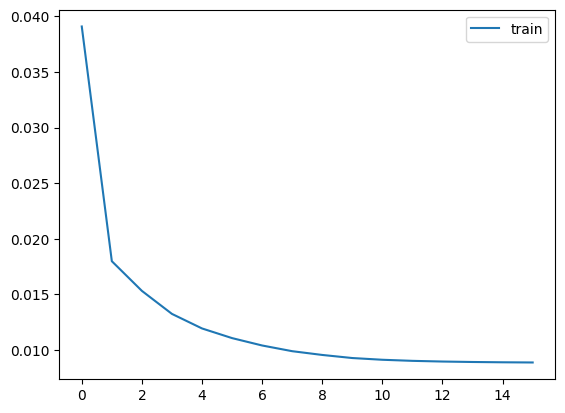

24/24 [==============================] - 0s 2ms/step
MAPE: 8.508349616403974
RMSE: 1512.1093371299871
Correlation 0.8324283414864897 with p-value 2.0296187482046388e-192


(8.508349616403974,
 1512.1093371299871,
 0.8324283414864897,
 2.0296187482046388e-192,
 array([12297.7535666 , 12042.62594414, 11999.75513832, 12314.81754034,
        13103.41032586, 14069.20286811, 14740.55240261, 15152.88916785,
        15109.65924155, 14723.73636257, 14386.88135418, 14152.91372373,
        14129.12358958, 14276.95342564, 14664.83932617, 15358.34825558,
        16033.47430614, 16470.25043402, 16314.44965695, 15604.24609834,
        14536.51701671, 13536.01375495, 12654.29757885, 12036.44804952,
        11715.77263276, 11484.95369655, 11421.99706513, 11636.04820614,
        12254.99266954, 13080.29753638, 13778.59899886, 14034.45508634,
        13798.01706485, 13296.75133397, 12855.71176867, 12586.4378666 ,
        12572.80279052, 12739.35545578, 13095.30391592, 13694.13156201,
        14240.339751  , 14652.94489809, 14472.61401976, 13821.62699976,
        12917.06513803, 12058.72246522, 11401.22175377, 10977.40527432,
        10691.73419961, 10525.59912373, 10497.72

In [ ]:
mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=True,
    use_all_predictors=False,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False,
    include_price_bool=True,
    include_climate_change_bool=False
)

run_full_model(
    df_lstm=df_lstm,
    predictions_wintertime=predictions_wintertime,
    huang=True,
    tan=False,
    predictors_list=predictors_list,
    df_test_prophet=df_test_prophet
)

# Best model without climate change related predictors

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/w0dhwfir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/pu3ncw7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17746', 'data', 'file=/tmp/tmp30dvtjm7/w0dhwfir.json', 'init=/tmp/tmp30dvtjm7/pu3ncw7j.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modelmyn_taab/prophet_model-20240524151207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:12:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['loadConsumption-60days-24h', 'nat-60days', 'sic-60days', 'loadConsumption-60days', 'loadConsumption-60days-7days', 'geopotential-60days']
['loadConsumption-60days-24h', 'nat-60days', 'sic-60days', 'loadConsumption-60days', 'loadConsumption-60days-7days', 'geopotential-60days', 'y', 'ds']
['loadConsumption-60days-24h', 'nat-60days', 'sic-60days', 'loadConsumption-60days', 'loadConsumption-60days-7days', 'geopotential-60days']
['loadConsumption-60days-24h', 'nat-60days', 'sic-60days', 'loadConsumption-60days', 'loadConsumption-60days-7days', 'geopotential-60days', 'y', 'ds']
23925 744
shape 1 7
Epoch 1/50
374/374 - 4s - loss: 0.0328 - 4s/epoch - 10ms/step
Epoch 2/50
374/374 - 1s - loss: 0.0140 - 1s/epoch - 4ms/step
Epoch 3/50
374/374 - 2s - loss: 0.0108 - 2s/epoch - 6ms/step
Epoch 4/50
374/374 - 2s - loss: 0.0100 - 2s/epoch - 6ms/step
Epoch 5/50
374/374 - 2s - loss: 0.0097 - 2s/epoch - 4ms/step
Epoch 6/50
374/374 - 2s - loss: 0.0095 - 2s/epoch - 4ms/step
Epoch 7/50
374/374 - 2s - loss:

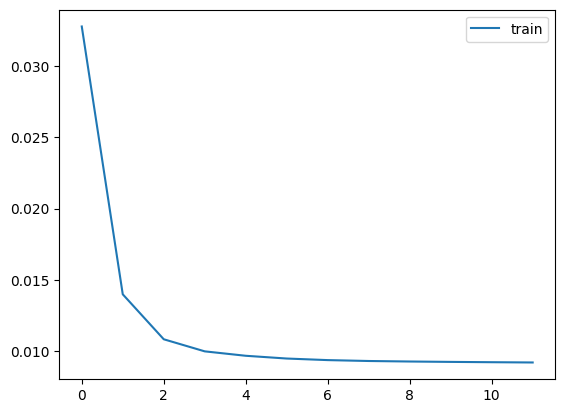

24/24 [==============================] - 0s 2ms/step
MAPE: 7.32420015549537
RMSE: 1314.5405729516385
Correlation 0.8316355872000366 with p-value 9.966810172556552e-192


(7.32420015549537,
 1314.5405729516385,
 0.8316355872000366,
 9.966810172556552e-192,
 array([12621.95564869, 12369.6204755 , 12317.71286932, 12613.45944606,
        13417.55192253, 14388.55874075, 15063.48861696, 15475.15442757,
        15428.37227576, 15071.14516779, 14756.49364561, 14536.88252723,
        14500.70145857, 14621.35571512, 14978.4403251 , 15672.25725464,
        16348.88560457, 16771.68542801, 16629.00405047, 15918.8650313 ,
        14861.36704926, 13873.97360197, 12995.88952694, 12367.87599346,
        12020.21542051, 11773.47505043, 11712.36130772, 11969.36344961,
        12643.06132532, 13497.52779738, 14181.61652379, 14441.85618152,
        14206.52555467, 13701.23984706, 13264.51803455, 12996.75090488,
        12978.73417556, 13145.4293388 , 13516.4276308 , 14133.42856228,
        14670.25233252, 15073.66028915, 14910.29306087, 14265.99577803,
        13340.74870456, 12468.85977728, 11763.02924535, 11267.24042126,
        10964.45712797, 10747.85316434, 10706.5891

In [ ]:
mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=True,
    use_all_predictors=False,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False,
    include_price_bool=False,
    include_climate_change_bool=True
)

run_full_model(
    df_lstm=df_lstm,
    predictions_wintertime=predictions_wintertime,
    huang=True,
    tan=False,
    predictors_list=predictors_list,
    df_test_prophet=df_test_prophet
)

# More days ahead

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/6jyp8stb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/nfkn6juw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29120', 'data', 'file=/tmp/tmp30dvtjm7/6jyp8stb.json', 'init=/tmp/tmp30dvtjm7/nfkn6juw.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modelcmaxqvj4/prophet_model-20240524140423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:04:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:04:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['dailyMeanTemperature-90days', 'nao-90days', 'other-90days', 'loadConsumption-90days-7days', 'geopotential-90days', 'loadConsumption-90days', 'biomass-90days', 'solarEnergy-90days', 'dailyPrecipitation-90days', 'nat-90days', 'windEnergy-90days', 'fixedGasPrice-90days', 'heatPumps-90days', 'variableGasPrice-90days', 'sic-90days', 'loadConsumption-90days-24h', 'fixedElectricityPrice-90days', 'dailyMeanWindspeed-90days', 'variableElectricityPrice-90days']
['dailyMeanTemperature-90days', 'nao-90days', 'other-90days', 'loadConsumption-90days-7days', 'geopotential-90days', 'loadConsumption-90days', 'biomass-90days', 'solarEnergy-90days', 'dailyPrecipitation-90days', 'nat-90days', 'windEnergy-90days', 'fixedGasPrice-90days', 'heatPumps-90days', 'variableGasPrice-90days', 'sic-90days', 'loadConsumption-90days-24h', 'fixedElectricityPrice-90days', 'dailyMeanWindspeed-90days', 'variableElectricityPrice-90days', 'y', 'ds']
['dailyMeanTemperature-90days', 'nao-90days', 'other-90days', 'loadConsum

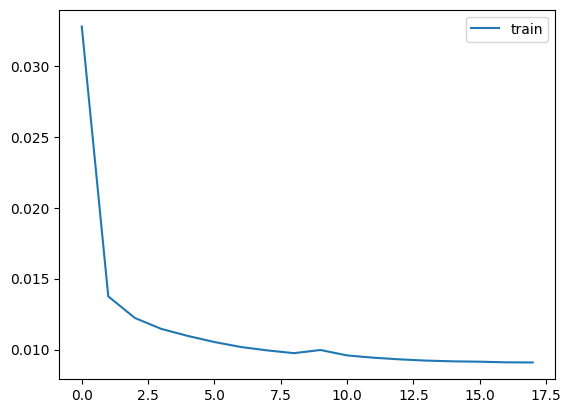

24/24 [==============================] - 0s 2ms/step
MAPE: 8.576402876802268
RMSE: 1505.345374313494
Correlation 0.7990389635487929 with p-value 4.347563408802939e-166


In [ ]:
n_days_lag_new = 90 # 3 months

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=True,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag_new,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False,
    include_price_bool=True
)

run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/6htgphdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/rl5m0w7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29659', 'data', 'file=/tmp/tmp30dvtjm7/6htgphdh.json', 'init=/tmp/tmp30dvtjm7/rl5m0w7g.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modelw91g60f7/prophet_model-20240524140552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:05:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['variableElectricityPrice-120days', 'dailyMeanWindspeed-120days', 'fixedElectricityPrice-120days', 'nao-120days', 'nat-120days', 'dailyMeanTemperature-120days', 'variableGasPrice-120days', 'loadConsumption-120days-24h', 'loadConsumption-120days', 'solarEnergy-120days', 'other-120days', 'loadConsumption-120days-7days', 'windEnergy-120days', 'heatPumps-120days', 'fixedGasPrice-120days', 'sic-120days', 'biomass-120days', 'dailyPrecipitation-120days', 'geopotential-120days']
['variableElectricityPrice-120days', 'dailyMeanWindspeed-120days', 'fixedElectricityPrice-120days', 'nao-120days', 'nat-120days', 'dailyMeanTemperature-120days', 'variableGasPrice-120days', 'loadConsumption-120days-24h', 'loadConsumption-120days', 'solarEnergy-120days', 'other-120days', 'loadConsumption-120days-7days', 'windEnergy-120days', 'heatPumps-120days', 'fixedGasPrice-120days', 'sic-120days', 'biomass-120days', 'dailyPrecipitation-120days', 'geopotential-120days', 'y', 'ds']
['variableElectricityPrice-120days'

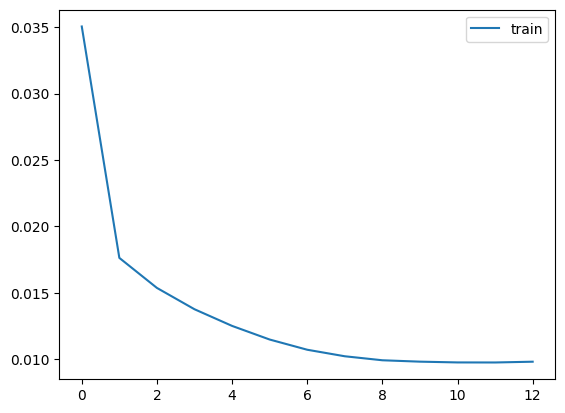

24/24 [==============================] - 1s 8ms/step
MAPE: 7.781500903619322
RMSE: 1431.5679142534775
Correlation 0.7898615447724252 with p-value 1.0333667012993107e-159


In [ ]:
n_days_lag_new = 120 # 4 months

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=True,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag_new,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False,
    include_price_bool=True
)

run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/7t47eu8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/36u95yb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26236', 'data', 'file=/tmp/tmp30dvtjm7/7t47eu8t.json', 'init=/tmp/tmp30dvtjm7/36u95yb2.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modelptxzt13u/prophet_model-20240524140712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:07:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:07:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['solarEnergy-105days', 'dailyPrecipitation-105days', 'nat-105days', 'dailyMeanWindspeed-105days', 'variableElectricityPrice-105days', 'loadConsumption-105days-7days', 'other-105days', 'loadConsumption-105days-24h', 'variableGasPrice-105days', 'nao-105days', 'heatPumps-105days', 'fixedElectricityPrice-105days', 'windEnergy-105days', 'loadConsumption-105days', 'biomass-105days', 'dailyMeanTemperature-105days', 'fixedGasPrice-105days', 'geopotential-105days', 'sic-105days']
['solarEnergy-105days', 'dailyPrecipitation-105days', 'nat-105days', 'dailyMeanWindspeed-105days', 'variableElectricityPrice-105days', 'loadConsumption-105days-7days', 'other-105days', 'loadConsumption-105days-24h', 'variableGasPrice-105days', 'nao-105days', 'heatPumps-105days', 'fixedElectricityPrice-105days', 'windEnergy-105days', 'loadConsumption-105days', 'biomass-105days', 'dailyMeanTemperature-105days', 'fixedGasPrice-105days', 'geopotential-105days', 'sic-105days', 'y', 'ds']
['solarEnergy-105days', 'dailyPreci

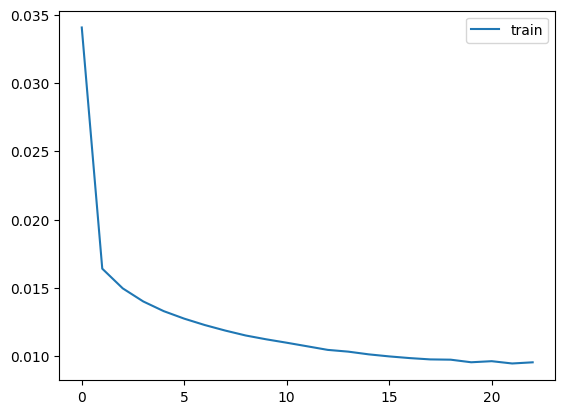

24/24 [==============================] - 0s 2ms/step
MAPE: 7.886644424060653
RMSE: 1418.8971550623046
Correlation 0.7843847525452499 with p-value 4.666768611668808e-156


In [ ]:
n_days_lag_new = 105 # 3.5 months

mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
    n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=True,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag_new,
    add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
    k_folds=3,
    huang=True,
    tan=False,
    include_price_bool=True
)

run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/kddjum_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/m0qz6qui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96499', 'data', 'file=/tmp/tmp30dvtjm7/kddjum_3.json', 'init=/tmp/tmp30dvtjm7/m0qz6qui.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modelks29jpkf/prophet_model-20240524142032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['sic-65days', 'variableGasPrice-65days', 'loadConsumption-65days', 'variableElectricityPrice-65days', 'fixedGasPrice-65days', 'solarEnergy-65days', 'other-65days', 'loadConsumption-65days-7days', 'geopotential-65days', 'fixedElectricityPrice-65days', 'windEnergy-65days', 'dailyMeanWindspeed-65days', 'nat-65days', 'biomass-65days', 'dailyPrecipitation-65days', 'loadConsumption-65days-24h', 'nao-65days', 'heatPumps-65days', 'dailyMeanTemperature-65days']
['sic-65days', 'variableGasPrice-65days', 'loadConsumption-65days', 'variableElectricityPrice-65days', 'fixedGasPrice-65days', 'solarEnergy-65days', 'other-65days', 'loadConsumption-65days-7days', 'geopotential-65days', 'fixedElectricityPrice-65days', 'windEnergy-65days', 'dailyMeanWindspeed-65days', 'nat-65days', 'biomass-65days', 'dailyPrecipitation-65days', 'loadConsumption-65days-24h', 'nao-65days', 'heatPumps-65days', 'dailyMeanTemperature-65days', 'y', 'ds']
['sic-65days', 'variableGasPrice-65days', 'loadConsumption-65days', 'vari

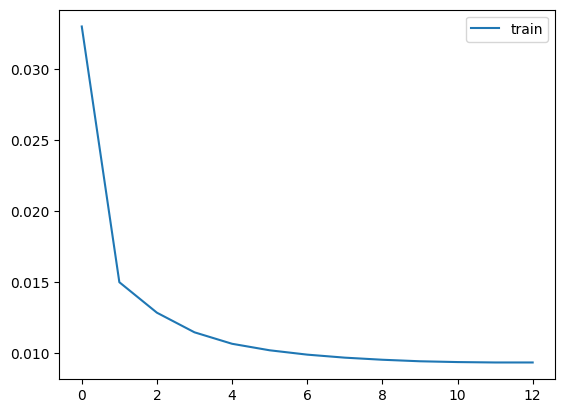

24/24 [==============================] - 0s 2ms/step
MAPE: 8.741538550067498
RMSE: 1545.5610783168288
Correlation 0.8361069202596015 with p-value 1.1277519645640535e-195
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/qq7_vqg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/ya8_lftg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80528', 'data', 'file=/tmp/tmp30dvtjm7/qq7_vqg9.json', 'init=/tmp/tmp30dvtjm7/ya8_lftg.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modelpxh_4lmx/prophet_model-20240524142228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['loadConsumption-70days-24h', 'geopotential-70days', 'dailyMeanTemperature-70days', 'fixedElectricityPrice-70days', 'windEnergy-70days', 'loadConsumption-70days-7days', 'other-70days', 'variableGasPrice-70days', 'nao-70days', 'fixedGasPrice-70days', 'loadConsumption-70days', 'biomass-70days', 'variableElectricityPrice-70days', 'heatPumps-70days', 'dailyMeanWindspeed-70days', 'solarEnergy-70days', 'sic-70days', 'dailyPrecipitation-70days', 'nat-70days']
['loadConsumption-70days-24h', 'geopotential-70days', 'dailyMeanTemperature-70days', 'fixedElectricityPrice-70days', 'windEnergy-70days', 'loadConsumption-70days-7days', 'other-70days', 'variableGasPrice-70days', 'nao-70days', 'fixedGasPrice-70days', 'loadConsumption-70days', 'biomass-70days', 'variableElectricityPrice-70days', 'heatPumps-70days', 'dailyMeanWindspeed-70days', 'solarEnergy-70days', 'sic-70days', 'dailyPrecipitation-70days', 'nat-70days', 'y', 'ds']
['loadConsumption-70days-24h', 'geopotential-70days', 'dailyMeanTemperatu

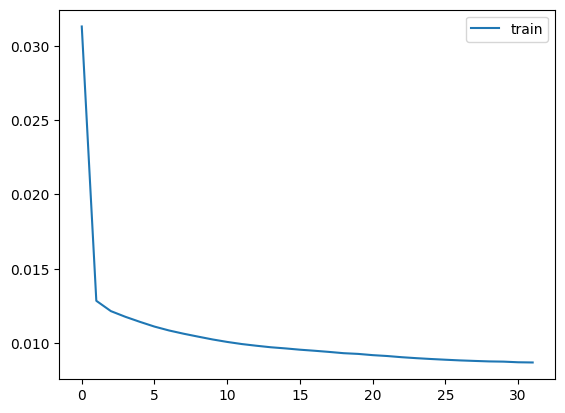

24/24 [==============================] - 0s 2ms/step
MAPE: 10.451365017058738
RMSE: 1729.3393871270196
Correlation 0.8427947398104629 with p-value 8.353532686774494e-202
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/wb8379_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/eu5tk_fc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72918', 'data', 'file=/tmp/tmp30dvtjm7/wb8379_7.json', 'init=/tmp/tmp30dvtjm7/eu5tk_fc.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modelzccxeyrb/prophet_model-20240524142451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['biomass-75days', 'loadConsumption-75days', 'solarEnergy-75days', 'variableElectricityPrice-75days', 'loadConsumption-75days-7days', 'nao-75days', 'fixedGasPrice-75days', 'other-75days', 'heatPumps-75days', 'loadConsumption-75days-24h', 'variableGasPrice-75days', 'dailyMeanTemperature-75days', 'fixedElectricityPrice-75days', 'sic-75days', 'dailyPrecipitation-75days', 'dailyMeanWindspeed-75days', 'windEnergy-75days', 'geopotential-75days', 'nat-75days']
['biomass-75days', 'loadConsumption-75days', 'solarEnergy-75days', 'variableElectricityPrice-75days', 'loadConsumption-75days-7days', 'nao-75days', 'fixedGasPrice-75days', 'other-75days', 'heatPumps-75days', 'loadConsumption-75days-24h', 'variableGasPrice-75days', 'dailyMeanTemperature-75days', 'fixedElectricityPrice-75days', 'sic-75days', 'dailyPrecipitation-75days', 'dailyMeanWindspeed-75days', 'windEnergy-75days', 'geopotential-75days', 'nat-75days', 'y', 'ds']
['biomass-75days', 'loadConsumption-75days', 'solarEnergy-75days', 'varia

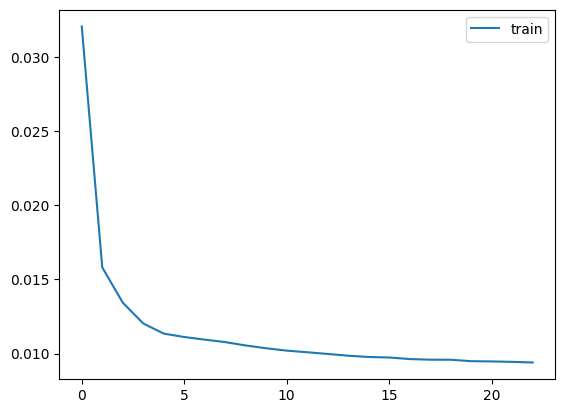

24/24 [==============================] - 0s 2ms/step
MAPE: 7.7207302783126455
RMSE: 1404.187841981745
Correlation 0.795683434621677 with p-value 1.0171588544343102e-163
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/mps_sumy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/v1vhc3sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91060', 'data', 'file=/tmp/tmp30dvtjm7/mps_sumy.json', 'init=/tmp/tmp30dvtjm7/v1vhc3sy.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modeldvsoqfyp/prophet_model-20240524142628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['variableElectricityPrice-80days', 'windEnergy-80days', 'loadConsumption-80days-7days', 'dailyMeanWindspeed-80days', 'nat-80days', 'fixedElectricityPrice-80days', 'solarEnergy-80days', 'biomass-80days', 'sic-80days', 'loadConsumption-80days', 'dailyMeanTemperature-80days', 'dailyPrecipitation-80days', 'variableGasPrice-80days', 'nao-80days', 'heatPumps-80days', 'loadConsumption-80days-24h', 'geopotential-80days', 'fixedGasPrice-80days', 'other-80days']
['variableElectricityPrice-80days', 'windEnergy-80days', 'loadConsumption-80days-7days', 'dailyMeanWindspeed-80days', 'nat-80days', 'fixedElectricityPrice-80days', 'solarEnergy-80days', 'biomass-80days', 'sic-80days', 'loadConsumption-80days', 'dailyMeanTemperature-80days', 'dailyPrecipitation-80days', 'variableGasPrice-80days', 'nao-80days', 'heatPumps-80days', 'loadConsumption-80days-24h', 'geopotential-80days', 'fixedGasPrice-80days', 'other-80days', 'y', 'ds']
['variableElectricityPrice-80days', 'windEnergy-80days', 'loadConsumption

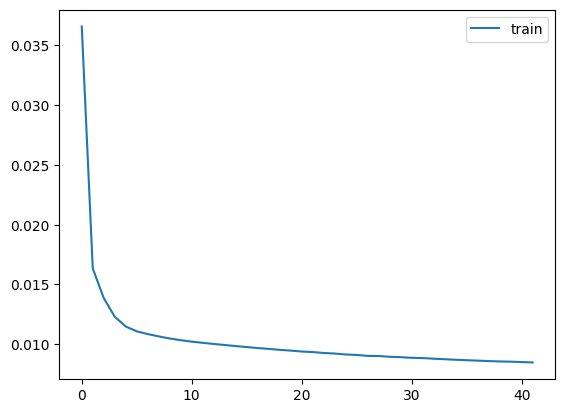

24/24 [==============================] - 0s 4ms/step
MAPE: 12.593713166705905
RMSE: 2073.2764795235917
Correlation 0.4972777835326977 with p-value 9.957122807886961e-48
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/x9lftvpx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/ua5v3q10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94389', 'data', 'file=/tmp/tmp30dvtjm7/x9lftvpx.json', 'init=/tmp/tmp30dvtjm7/ua5v3q10.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modelx740t06a/prophet_model-20240524142831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['dailyPrecipitation-85days', 'solarEnergy-85days', 'fixedGasPrice-85days', 'sic-85days', 'dailyMeanTemperature-85days', 'biomass-85days', 'variableElectricityPrice-85days', 'geopotential-85days', 'nat-85days', 'other-85days', 'dailyMeanWindspeed-85days', 'loadConsumption-85days-24h', 'nao-85days', 'fixedElectricityPrice-85days', 'loadConsumption-85days', 'heatPumps-85days', 'windEnergy-85days', 'loadConsumption-85days-7days', 'variableGasPrice-85days']
['dailyPrecipitation-85days', 'solarEnergy-85days', 'fixedGasPrice-85days', 'sic-85days', 'dailyMeanTemperature-85days', 'biomass-85days', 'variableElectricityPrice-85days', 'geopotential-85days', 'nat-85days', 'other-85days', 'dailyMeanWindspeed-85days', 'loadConsumption-85days-24h', 'nao-85days', 'fixedElectricityPrice-85days', 'loadConsumption-85days', 'heatPumps-85days', 'windEnergy-85days', 'loadConsumption-85days-7days', 'variableGasPrice-85days', 'y', 'ds']
['dailyPrecipitation-85days', 'solarEnergy-85days', 'fixedGasPrice-85days

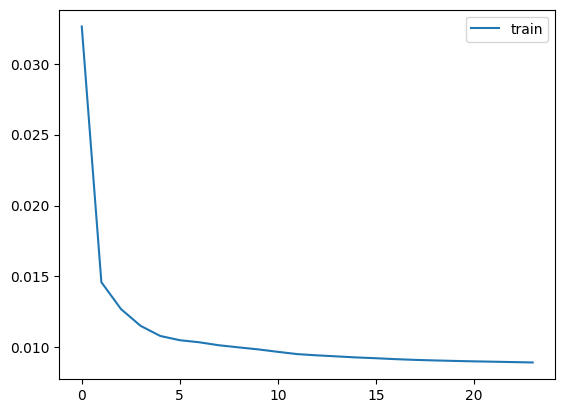

24/24 [==============================] - 1s 3ms/step
MAPE: 9.642806069286678
RMSE: 1679.9643376415906
Correlation 0.6853039079597062 with p-value 2.7884647414462188e-104
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/sv5iaq7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/iq_ax1ze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68373', 'data', 'file=/tmp/tmp30dvtjm7/sv5iaq7i.json', 'init=/tmp/tmp30dvtjm7/iq_ax1ze.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modele6zmp9dp/prophet_model-20240524143052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:30:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['dailyMeanTemperature-90days', 'nao-90days', 'other-90days', 'loadConsumption-90days-7days', 'geopotential-90days', 'loadConsumption-90days', 'biomass-90days', 'solarEnergy-90days', 'dailyPrecipitation-90days', 'nat-90days', 'windEnergy-90days', 'fixedGasPrice-90days', 'heatPumps-90days', 'variableGasPrice-90days', 'sic-90days', 'loadConsumption-90days-24h', 'fixedElectricityPrice-90days', 'dailyMeanWindspeed-90days', 'variableElectricityPrice-90days']
['dailyMeanTemperature-90days', 'nao-90days', 'other-90days', 'loadConsumption-90days-7days', 'geopotential-90days', 'loadConsumption-90days', 'biomass-90days', 'solarEnergy-90days', 'dailyPrecipitation-90days', 'nat-90days', 'windEnergy-90days', 'fixedGasPrice-90days', 'heatPumps-90days', 'variableGasPrice-90days', 'sic-90days', 'loadConsumption-90days-24h', 'fixedElectricityPrice-90days', 'dailyMeanWindspeed-90days', 'variableElectricityPrice-90days', 'y', 'ds']
['dailyMeanTemperature-90days', 'nao-90days', 'other-90days', 'loadConsum

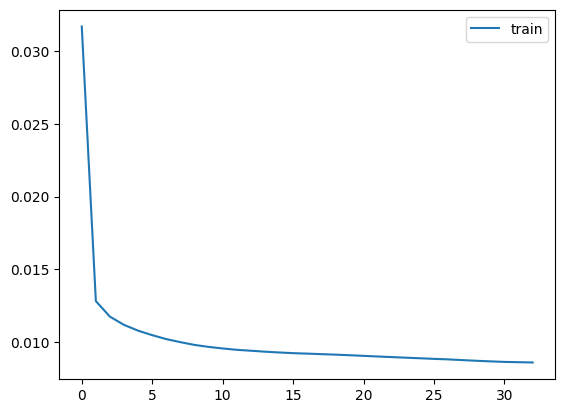

24/24 [==============================] - 0s 2ms/step
MAPE: 8.552782701886695
RMSE: 1504.9953076446452
Correlation 0.7893352911351964 with p-value 2.345102998822562e-159
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/b73m5bj_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/ri703_aw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49416', 'data', 'file=/tmp/tmp30dvtjm7/b73m5bj_.json', 'init=/tmp/tmp30dvtjm7/ri703_aw.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modeltsrwsa9e/prophet_model-20240524143232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:32:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:32:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['loadConsumption-95days-7days', 'geopotential-95days', 'fixedGasPrice-95days', 'heatPumps-95days', 'loadConsumption-95days', 'loadConsumption-95days-24h', 'biomass-95days', 'fixedElectricityPrice-95days', 'dailyMeanWindspeed-95days', 'variableElectricityPrice-95days', 'variableGasPrice-95days', 'windEnergy-95days', 'other-95days', 'dailyMeanTemperature-95days', 'nao-95days', 'sic-95days', 'dailyPrecipitation-95days', 'solarEnergy-95days', 'nat-95days']
['loadConsumption-95days-7days', 'geopotential-95days', 'fixedGasPrice-95days', 'heatPumps-95days', 'loadConsumption-95days', 'loadConsumption-95days-24h', 'biomass-95days', 'fixedElectricityPrice-95days', 'dailyMeanWindspeed-95days', 'variableElectricityPrice-95days', 'variableGasPrice-95days', 'windEnergy-95days', 'other-95days', 'dailyMeanTemperature-95days', 'nao-95days', 'sic-95days', 'dailyPrecipitation-95days', 'solarEnergy-95days', 'nat-95days', 'y', 'ds']
['loadConsumption-95days-7days', 'geopotential-95days', 'fixedGasPrice-95

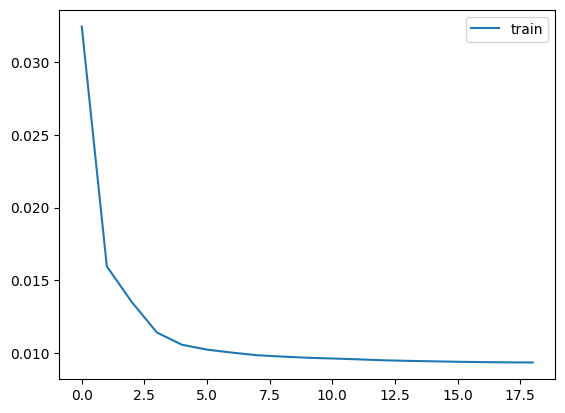

24/24 [==============================] - 0s 2ms/step
MAPE: 7.891109700582623
RMSE: 1427.1344546049759
Correlation 0.8051911240934534 with p-value 1.4973479350453239e-170
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/ft6n5_jf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/9arn8ebq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33304', 'data', 'file=/tmp/tmp30dvtjm7/ft6n5_jf.json', 'init=/tmp/tmp30dvtjm7/9arn8ebq.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_model08gngbuo/prophet_model-20240524143356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:34:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['nao-100days', 'biomass-100days', 'fixedElectricityPrice-100days', 'heatPumps-100days', 'variableElectricityPrice-100days', 'dailyMeanTemperature-100days', 'geopotential-100days', 'loadConsumption-100days-24h', 'windEnergy-100days', 'loadConsumption-100days', 'sic-100days', 'nat-100days', 'fixedGasPrice-100days', 'variableGasPrice-100days', 'loadConsumption-100days-7days', 'other-100days', 'dailyMeanWindspeed-100days', 'solarEnergy-100days', 'dailyPrecipitation-100days']
['nao-100days', 'biomass-100days', 'fixedElectricityPrice-100days', 'heatPumps-100days', 'variableElectricityPrice-100days', 'dailyMeanTemperature-100days', 'geopotential-100days', 'loadConsumption-100days-24h', 'windEnergy-100days', 'loadConsumption-100days', 'sic-100days', 'nat-100days', 'fixedGasPrice-100days', 'variableGasPrice-100days', 'loadConsumption-100days-7days', 'other-100days', 'dailyMeanWindspeed-100days', 'solarEnergy-100days', 'dailyPrecipitation-100days', 'y', 'ds']
['nao-100days', 'biomass-100days', 

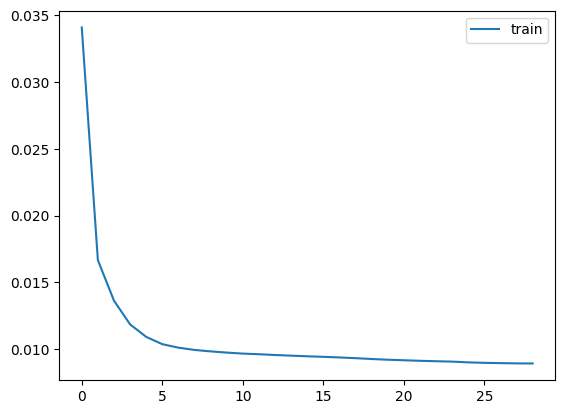

24/24 [==============================] - 0s 2ms/step
MAPE: 8.049148561730133
RMSE: 1488.2476445219831
Correlation 0.8118073936570722 with p-value 1.5629611282604913e-175
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/ndk1mfac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/vvd3eiu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22842', 'data', 'file=/tmp/tmp30dvtjm7/ndk1mfac.json', 'init=/tmp/tmp30dvtjm7/vvd3eiu4.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_model5wmsksni/prophet_model-20240524143601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['solarEnergy-105days', 'dailyPrecipitation-105days', 'nat-105days', 'dailyMeanWindspeed-105days', 'variableElectricityPrice-105days', 'loadConsumption-105days-7days', 'other-105days', 'loadConsumption-105days-24h', 'variableGasPrice-105days', 'nao-105days', 'heatPumps-105days', 'fixedElectricityPrice-105days', 'windEnergy-105days', 'loadConsumption-105days', 'biomass-105days', 'dailyMeanTemperature-105days', 'fixedGasPrice-105days', 'geopotential-105days', 'sic-105days']
['solarEnergy-105days', 'dailyPrecipitation-105days', 'nat-105days', 'dailyMeanWindspeed-105days', 'variableElectricityPrice-105days', 'loadConsumption-105days-7days', 'other-105days', 'loadConsumption-105days-24h', 'variableGasPrice-105days', 'nao-105days', 'heatPumps-105days', 'fixedElectricityPrice-105days', 'windEnergy-105days', 'loadConsumption-105days', 'biomass-105days', 'dailyMeanTemperature-105days', 'fixedGasPrice-105days', 'geopotential-105days', 'sic-105days', 'y', 'ds']
['solarEnergy-105days', 'dailyPreci

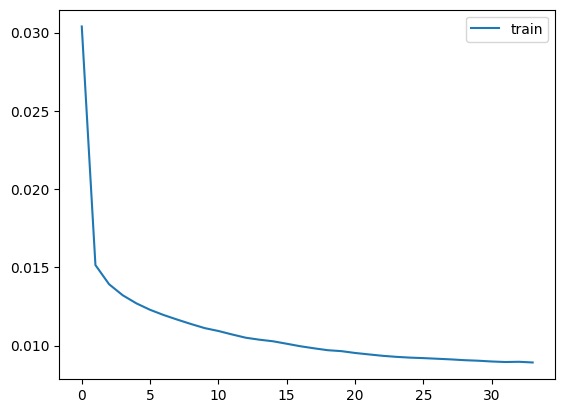

24/24 [==============================] - 0s 2ms/step
MAPE: 8.451734172982446
RMSE: 1479.5682462960326
Correlation 0.7570830407408264 with p-value 2.569273536026235e-139
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/5aznzfp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/gokkqj1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77604', 'data', 'file=/tmp/tmp30dvtjm7/5aznzfp9.json', 'init=/tmp/tmp30dvtjm7/gokkqj1z.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modele0ltlons/prophet_model-20240524143740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:37:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['loadConsumption-110days', 'sic-110days', 'loadConsumption-110days-7days', 'loadConsumption-110days-24h', 'dailyMeanTemperature-110days', 'dailyPrecipitation-110days', 'windEnergy-110days', 'biomass-110days', 'solarEnergy-110days', 'variableElectricityPrice-110days', 'nao-110days', 'geopotential-110days', 'fixedElectricityPrice-110days', 'dailyMeanWindspeed-110days', 'fixedGasPrice-110days', 'heatPumps-110days', 'variableGasPrice-110days', 'nat-110days', 'other-110days']
['loadConsumption-110days', 'sic-110days', 'loadConsumption-110days-7days', 'loadConsumption-110days-24h', 'dailyMeanTemperature-110days', 'dailyPrecipitation-110days', 'windEnergy-110days', 'biomass-110days', 'solarEnergy-110days', 'variableElectricityPrice-110days', 'nao-110days', 'geopotential-110days', 'fixedElectricityPrice-110days', 'dailyMeanWindspeed-110days', 'fixedGasPrice-110days', 'heatPumps-110days', 'variableGasPrice-110days', 'nat-110days', 'other-110days', 'y', 'ds']
['loadConsumption-110days', 'sic-11

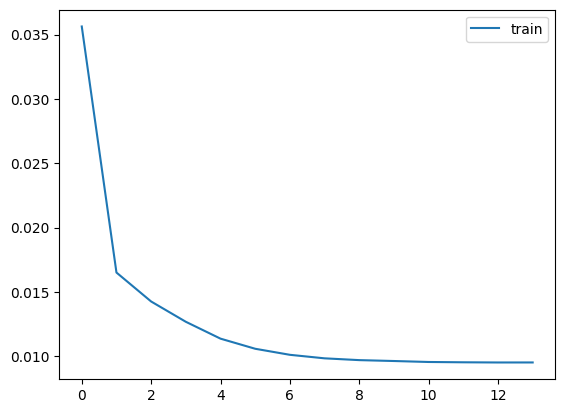

24/24 [==============================] - 0s 3ms/step
MAPE: 8.610307445646379
RMSE: 1580.36674165703
Correlation 0.7413371674104449 with p-value 1.224527157731852e-130
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/o41vdt_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/bmvnzwdb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15553', 'data', 'file=/tmp/tmp30dvtjm7/o41vdt_a.json', 'init=/tmp/tmp30dvtjm7/bmvnzwdb.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_model8p9o2801/prophet_model-20240524143907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:39:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['dailyMeanWindspeed-115days', 'dailyPrecipitation-115days', 'other-115days', 'variableGasPrice-115days', 'loadConsumption-115days-24h', 'nao-115days', 'fixedGasPrice-115days', 'geopotential-115days', 'dailyMeanTemperature-115days', 'windEnergy-115days', 'heatPumps-115days', 'nat-115days', 'biomass-115days', 'loadConsumption-115days', 'loadConsumption-115days-7days', 'variableElectricityPrice-115days', 'solarEnergy-115days', 'fixedElectricityPrice-115days', 'sic-115days']
['dailyMeanWindspeed-115days', 'dailyPrecipitation-115days', 'other-115days', 'variableGasPrice-115days', 'loadConsumption-115days-24h', 'nao-115days', 'fixedGasPrice-115days', 'geopotential-115days', 'dailyMeanTemperature-115days', 'windEnergy-115days', 'heatPumps-115days', 'nat-115days', 'biomass-115days', 'loadConsumption-115days', 'loadConsumption-115days-7days', 'variableElectricityPrice-115days', 'solarEnergy-115days', 'fixedElectricityPrice-115days', 'sic-115days', 'y', 'ds']
['dailyMeanWindspeed-115days', 'dai

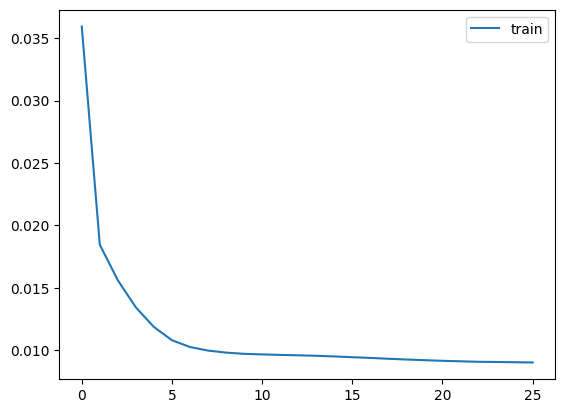

24/24 [==============================] - 1s 7ms/step
MAPE: 7.89199510575151
RMSE: 1429.87112613038
Correlation 0.7978976510230243 with p-value 2.8124777906364946e-165
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/tigo3brx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30dvtjm7/5p3cxy8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29681', 'data', 'file=/tmp/tmp30dvtjm7/tigo3brx.json', 'init=/tmp/tmp30dvtjm7/5p3cxy8y.json', 'output', 'file=/tmp/tmp30dvtjm7/prophet_modeltk2qjgkc/prophet_model-20240524144108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['variableElectricityPrice-120days', 'dailyMeanWindspeed-120days', 'fixedElectricityPrice-120days', 'nao-120days', 'nat-120days', 'dailyMeanTemperature-120days', 'variableGasPrice-120days', 'loadConsumption-120days-24h', 'loadConsumption-120days', 'solarEnergy-120days', 'other-120days', 'loadConsumption-120days-7days', 'windEnergy-120days', 'heatPumps-120days', 'fixedGasPrice-120days', 'sic-120days', 'biomass-120days', 'dailyPrecipitation-120days', 'geopotential-120days']
['variableElectricityPrice-120days', 'dailyMeanWindspeed-120days', 'fixedElectricityPrice-120days', 'nao-120days', 'nat-120days', 'dailyMeanTemperature-120days', 'variableGasPrice-120days', 'loadConsumption-120days-24h', 'loadConsumption-120days', 'solarEnergy-120days', 'other-120days', 'loadConsumption-120days-7days', 'windEnergy-120days', 'heatPumps-120days', 'fixedGasPrice-120days', 'sic-120days', 'biomass-120days', 'dailyPrecipitation-120days', 'geopotential-120days', 'y', 'ds']
['variableElectricityPrice-120days'

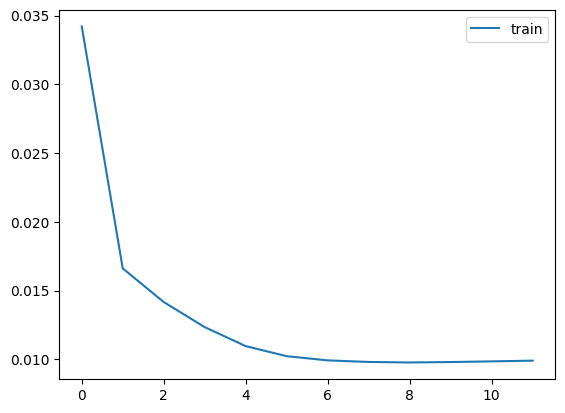

24/24 [==============================] - 0s 2ms/step
MAPE: 8.291557076657194
RMSE: 1514.599042695919
Correlation 0.7708452964865682 with p-value 1.828157036466784e-147


In [ ]:
mape_list, rmse_list, corr_test_list = [], [], []

for i in range(65, 121, 5):
  n_days_lag_new = i # 3.5 months

  _, _, _, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
      n_predictors=n_predictors,
      alpha=0.05,
      use_top_n_predictors=False,
      use_all_predictors=True,
      use_no_predictors=False,
      known_features_list=known_features_list,
      start_test_wintertime=start_test_wintertime,
      n_days_lag=n_days_lag_new,
      add_seasonality=True,
      fourier_weekly=1,
      fourier_annual=1,
      automatic=True,
      k_folds=3,
      huang=True,
      tan=False,
      include_price_bool=True
  )

  mape, rmse, corr_test, _, _, _ = run_full_model(df_lstm=df_lstm, predictions_wintertime=predictions_wintertime, huang=True, tan=False, predictors_list=predictors_list, df_test_prophet=df_test_prophet)
  mape_list.append(mape)
  rmse_list.append(rmse)
  corr_test_list.append(corr_test)

In [ ]:
temp_mape_list = [1, 2, 3]

In [ ]:
total = mape_60 + temp_mape_list

In [ ]:
total

[7.16, 1, 2, 3]

In [ ]:
mape_60 = [7.16 ]
pcc_60 = [0.84]
rmse_60 = [1288.49]

new_mape_list = mape_60 + mape_list
new_rmse_list = rmse_60 + rmse_list
new_corr_list = pcc_60 + corr_test_list


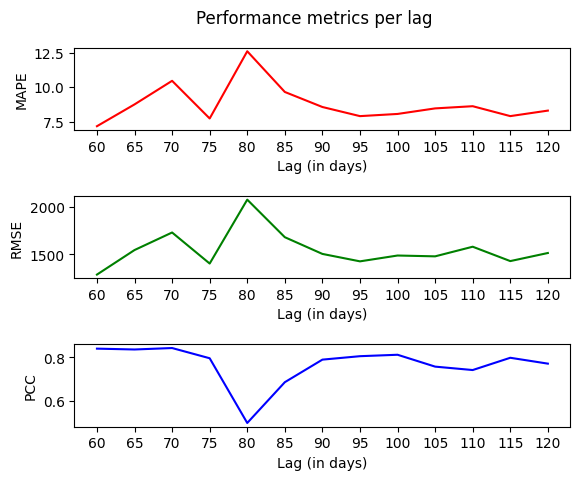

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nbr_days_lag = [i for i in range(60, 121, 5)]

fig, axs = plt.subplots(3)
fig.suptitle('Performance metrics per lag')


axs[0].plot(nbr_days_lag, new_mape_list, color="red")
axs[0].set_ylabel('MAPE')
axs[0].set_xlabel('Lag (in days)')
axs[0].set_xticks(nbr_days_lag)

axs[1].plot(nbr_days_lag, new_rmse_list, color="green")
axs[1].set_ylabel('RMSE')
axs[1].set_xlabel('Lag (in days)')
axs[1].set_xticks(nbr_days_lag)


axs[2].plot(nbr_days_lag, new_corr_list, color="blue")
axs[2].set_ylabel('PCC')
axs[2].set_xlabel('Lag (in days)')
axs[2].set_xticks(nbr_days_lag)

plt.subplots_adjust(hspace=0.8, top=0.9)

plt.show()

# Plot loss

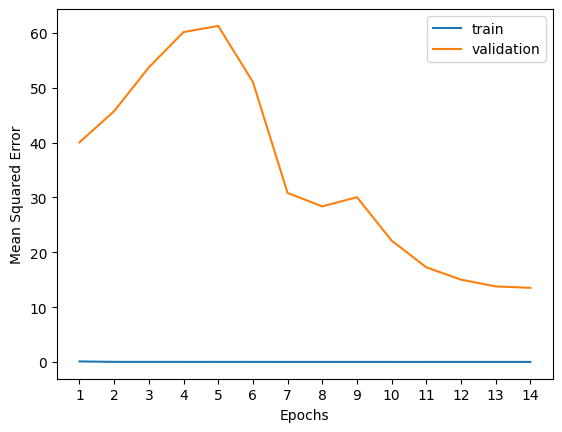

In [ ]:
losses = [0.1002, 0.0187, 0.0164, 0.0147, 0.0134, 0.0121, 0.0109, 0.0096, 0.0089, 0.0085, 0.0082, 0.0082, 0.0083, 0.0083]


val_losses = [40.0472,45.7444,53.7300 ,60.1686,61.2890,51.0758 , 30.8289 ,28.3694 ,30.0515 ,22.1414,17.2631 ,15.0151,13.7834 , 13.5191]

epochs = [i + 1 for i in range(len(val_losses))]

plt.plot(epochs,losses,  label='train')
plt.plot(epochs,val_losses, label='validation')

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.xticks(epochs)
plt.legend()
plt.show()

In [ ]:
# np.random.seed(42)
# tf.random.set_seed(42)

# mape_list, rmse_list, corr_list, predictions_wintertime, df_lstm, predictors_list, df_test_prophet = run_setup(
#     n_predictors=n_predictors,
#     alpha=0.05,
#     use_top_n_predictors=False,
#     use_all_predictors=True,
#     use_no_predictors=False,
#     known_features_list=known_features_list,
#     start_test_wintertime=start_test_wintertime,
#     n_days_lag=n_days_lag,
#     add_seasonality=True,
#     fourier_weekly=1,
#     fourier_annual=1,
#     automatic=True,
#     k_folds=3,
#     huang=False,
#     tan=True,
#     include_price_bool=True,
#     include_climate_change_bool=True
# )


df_train_prophet, df_test_prophet, predictors_list = preprocess_data(
 n_predictors=n_predictors,
    alpha=0.05,
    use_top_n_predictors=False,
    use_all_predictors=True,
    use_no_predictors=False,
    known_features_list=known_features_list,
    start_test_wintertime=start_test_wintertime,
    n_days_lag=n_days_lag,
    include_price_bool=True,
    include_climate_change_bool=True
)

# intialize model
model = initialize_prophet(
    regressors=predictors_list,
 add_seasonality=True,
    fourier_weekly=1,
    fourier_annual=1,
    automatic=True,
)

# fit model
model.fit(df_train_prophet)

predictions_train_validation = model.predict(df_train_prophet)
predictions_wintertime = model.predict(df_test_prophet)

# combine predictions
df_lstm = combine_prophet_predictions_and_target(
  prophet_forecast=predictions_train_validation,
  df_subset=df_train_prophet,
  # prophet_columns_to_select=['trend', 'additive_terms', 'yearly', 'weekly', 'daily', 'yhat', 'ds'],
  prophet_columns_to_select=['yhat', 'ds'],
  predictors_to_select=predictors_list
)

All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ewdachs/x5xw7lo2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ewdachs/n7i_qx1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63312', 'data', 'file=/tmp/tmp7ewdachs/x5xw7lo2.json', 'init=/tmp/tmp7ewdachs/n7i_qx1s.json', 'output', 'file=/tmp/tmp7ewdachs/prophet_modelf2v_xgdd/prophet_model-20240529174724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['nao-60days', 'fixedElectricityPrice-60days', 'heatPumps-60days', 'loadConsumption-60days-24h', 'fixedGasPrice-60days', 'dailyPrecipitation-60days', 'dailyMeanWindspeed-60days', 'geopotential-60days', 'sic-60days', 'nat-60days', 'windEnergy-60days', 'variableGasPrice-60days', 'solarEnergy-60days', 'loadConsumption-60days-7days', 'dailyMeanTemperature-60days', 'variableElectricityPrice-60days', 'biomass-60days', 'other-60days', 'loadConsumption-60days']
['nao-60days', 'fixedElectricityPrice-60days', 'heatPumps-60days', 'loadConsumption-60days-24h', 'fixedGasPrice-60days', 'dailyPrecipitation-60days', 'dailyMeanWindspeed-60days', 'geopotential-60days', 'sic-60days', 'nat-60days', 'windEnergy-60days', 'variableGasPrice-60days', 'solarEnergy-60days', 'loadConsumption-60days-7days', 'dailyMeanTemperature-60days', 'variableElectricityPrice-60days', 'biomass-60days', 'other-60days', 'loadConsumption-60days', 'y', 'ds']


In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

for train_idx, test_idx in tscv.split(df_lstm):
  end_train_idx, start_test_idx = train_idx.max(), test_idx.min()

  print(train_idx)
  print(test_idx)
  print()

[   0    1    2 ... 5979 5980 5981]
[ 5982  5983  5984 ... 11960 11961 11962]

[    0     1     2 ... 11960 11961 11962]
[11963 11964 11965 ... 17941 17942 17943]

[    0     1     2 ... 17941 17942 17943]
[17944 17945 17946 ... 23922 23923 23924]



# Check if k fold cv also gives bad results if we have folds of the same size

In [ ]:
wat we zien is dat het model gewoon meer epochs en meer training data / rondes nodig heeft.

in het begin overfit het idd enorm maar dat is omdat het nog niet genoeg gezien heeft. xzodra er meer epochs zijn geweest kan eht model beter tunen.
idem dito voor wanneer er meer trainings voorbeelden zinjn.


voor alle modellen wel gewoon met oude epochs trainen.
en voor het overfittende model laten zien dat als we bijv. meer epochs doen dat dat dan minder wordt.
dus dat het gewoon meer epochs/iteraties nodig heeft.
